In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,8]

import seaborn as sns
import plotly.express as px

from scipy import stats
from collections import defaultdict

from ipywidgets import interact, interact_manual
import ipywidgets as widgets
import folium
from folium import plugins

In [2]:
from IPython.core.display import HTML
css = open('Style/style-table.css').read() + open('Style/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

# Data loading

> The data here was already checked and cleaned.The whole process and analysis  is available in the [github repo](https://github.com/FernandoMeiraFilho/Edmonton-Library-EDA) with the name of **Edmonton Library - Data Manipulation and Preparation.ipynb.**

#### Library holds Dataset - Main dataset

In [3]:
data = pd.read_csv('library_ranks_prepared.csv')#.iloc[:,7:].drop(['pubdate'], axis=1)
data = data.rename(columns={'genre':'genre2', 'genre_fixed':'genre'}) # getting improved genre column
data = data.drop(['genre2'], axis=1)

#creating holding_year column
data['date'] = pd.to_datetime(data['date'])
data['hold_year'] = data['date'].dt.year

data.head(1)#.to_html()

,row_id,branch_id,branch_name,holds,title,author,date,url,google_rating,publishing_Date,genre,hold_year
0,EPLLON20150316The girl on the train / Paula Ha...,EPLLON,Londonderry Branch,36,The girl on the train,Hawkins Paula,2015-03-16,http://epl.bibliocommons.com/search?t=smart&q=...,3.5,2015.0,Fiction,2015


In [4]:
include =['object', 'float', 'int']
data.describe(include = include).fillna(0).loc[['count', 'unique'], :]#.to_html()

,row_id,branch_id,branch_name,holds,title,author,url,google_rating,publishing_Date,genre,hold_year
count,32300,32300,32300,32300.0,32300,32134,32300,23963.0,32300.0,32289,32300.0
unique,32300,22,22,0.0,3312,2375,3414,0.0,0.0,63,0.0


#### branch info Dataset - additional dataset

In [5]:
branch_info = pd.read_csv('branch_info.csv')
branch_info.head()

,Branch ID,Branch,Address,Latitude,Longitude
0,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
1,EPLRIV,Riverbend,"460 Riverbend Square, Rabbit Hill Road & Terwi...",53.468394,-113.583769
2,EPLESQ,Enterprise Square (Downtown),10212 Jasper Avenue NW,53.541194,-113.496835
3,EPLJPL,Jasper Place,9010 - 156 Street,53.523226,-113.590400
4,EPLLHL,Lois Hole (Callingwood),17650 69 Avenue,53.503771,-113.626074


# Data Analysis

### Some questions to solve:

 - Is the total number of holdings growing (or decreasing)?
 - Is there any pattern concerning the published date? 
 - Can we conclude anything using the google books rating?
 - What are the most popular books?
 - Are the popular books popular in all branchs?
 - Are there any patterns concerning the genre of books? what about genre in different branches?
 

### - 'Is the total number of holdings growing (or decreasing)??' 

#### Data availability

First, let's check the data availability for the all the years.

In [6]:
# adding col with the hold_month
data['hold_month'] = data['date'].dt.month

#counting number of months present by year of data presented
holdData = data[['hold_year', 'hold_month']]
holdData_g = holdData.groupby(['hold_year', 'hold_month']).agg(appearances=('hold_month', 'size'))
holdData_g
holdData_g = holdData_g.sort_values(['hold_year', 'hold_month']).reset_index()
holdData_g = holdData_g.groupby(['hold_year']).agg(total_data_points=('appearances', 'sum'),
                                                  number_of_months=('hold_month', 'size')).reset_index()
holdData_g.to_html(escape=False)#.loc[:,'total_data_points'].sum()

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>hold_year</th>\n      <th>total_data_points</th>\n      <th>number_of_months</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>0</th>\n      <td>2015</td>\n      <td>8644</td>\n      <td>11</td>\n    </tr>\n    <tr>\n      <th>1</th>\n      <td>2016</td>\n      <td>8709</td>\n      <td>11</td>\n    </tr>\n    <tr>\n      <th>2</th>\n      <td>2017</td>\n      <td>6481</td>\n      <td>9</td>\n    </tr>\n    <tr>\n      <th>3</th>\n      <td>2018</td>\n      <td>8256</td>\n      <td>10</td>\n    </tr>\n    <tr>\n      <th>4</th>\n      <td>2019</td>\n      <td>210</td>\n      <td>1</td>\n    </tr>\n  </tbody>\n</table>'

**We don't have any years with complete data**. If we take off 2019, 2017 is the year with less data, and 2018 just slightly better.

#### General analysis

In [7]:
plt.rcParams.update({'font.size': 15})

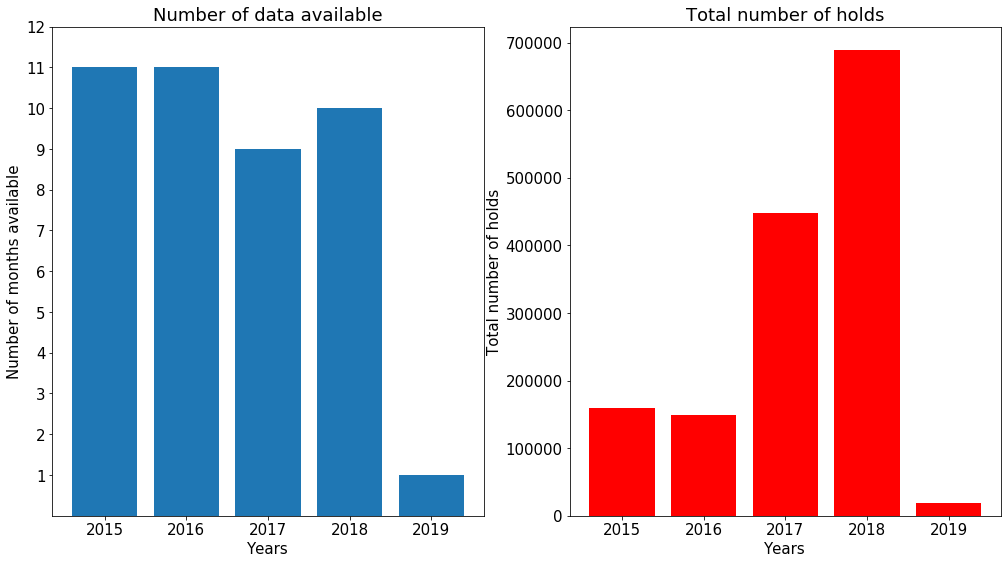

In [8]:
holdTotal = data[['hold_year', 'holds', 'branch_id', 'branch_name']]
hold_g = holdTotal.groupby(['hold_year']).agg(totalHolds=('holds', 'sum')).reset_index()

fig0, ax0 = plt.subplots(1, 2, figsize=(17,9))

ax0[0].bar(holdData_g.hold_year, holdData_g.number_of_months)
ax0[0].set_ylabel('Number of months available')
ax0[0].set_xlabel('Years')
ax0[0].title.set_text('Number of data available')
ax0[0].set_yticks(list(range(1,13)))
ax0[1].bar(hold_g.hold_year, hold_g.totalHolds, color='red')
ax0[1].set_ylabel('Total number of holds')
ax0[1].set_xlabel('Years')
ax0[1].title.set_text('Total number of holds')

plt.savefig('imgs/data_avail_holds.png')

Interesting points:

**2017 and 2018 show evolution in the total number of holds** even though we know we have incomplete data, and that this exact years have less data than 2015 and 2016.

#### Branch analysis

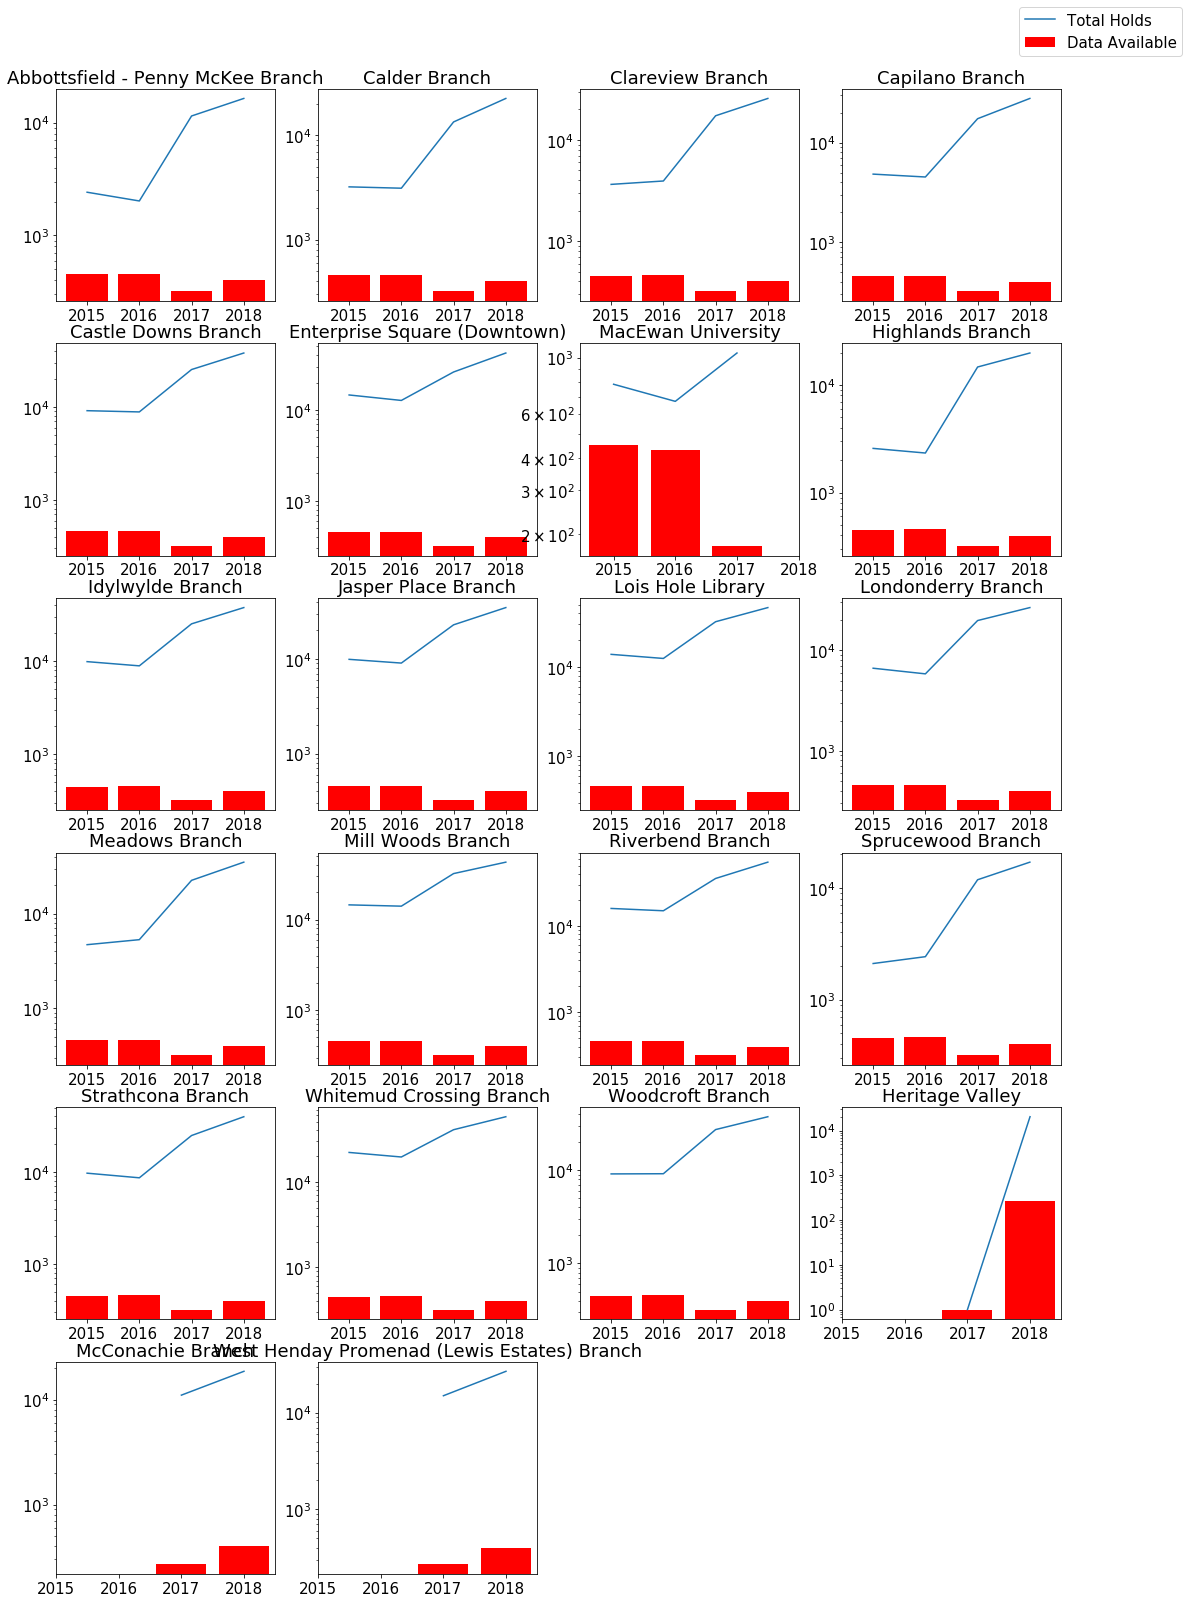

In [9]:
holdbranch = holdTotal.groupby(['hold_year', 'branch_id', 'branch_name']).agg(total_holds=('holds', 'sum'),
                                                                        data_available=('hold_year', 'size'))
holdbranch = holdbranch.reset_index()
holdbranch = holdbranch[holdbranch.hold_year != 2019]

years = [2015, 2016, 2017, 2018] # lets leave 019 once that it is an incomplete year - informartion wise
branches = list(holdbranch.branch_name.unique())

ncol = 4
nrow = 6
fig, ax = plt.subplots(nrow, ncol, figsize=(18,25))

row = 0
col = 0
for count,branch in zip(range(ncol*nrow),branches): 
    if col == 4:
        col = 0
        row+=1
    hb = holdbranch[holdbranch.branch_name==branch]
    ax[row,col].plot(hb.hold_year, hb.total_holds, label='Total Holds')
    ax[row,col].bar(hb.hold_year, hb.data_available, log=True, color='red', label='Data Available')
    ax[row,col].title.set_text(branch)
    ax[row,col].set_xticks(years)
    
    col += 1

fig.legend(labels=['Total Holds', 'Data Available'], loc='upper right')
plt.subplots_adjust(top=0.95)
plt.title('Number of holds per year - per branch')

ax[-1,-1].set_visible(False)
ax[-1,-2].set_visible(False)

plt.savefig('imgs/branch_avail.png')

Some interesting points to observe:

- In the majority of the branches, even though we have less data in the years of 2017 and 2018, we still have a growing number of total holds
- The branches where we have only 2017 and 2018 of data (maybe newer branches or newer to this dataset data collection) , we have the number of holds seems to follow the bigger availability of data.

### - 'Is there any pattern concerning the published date?' 

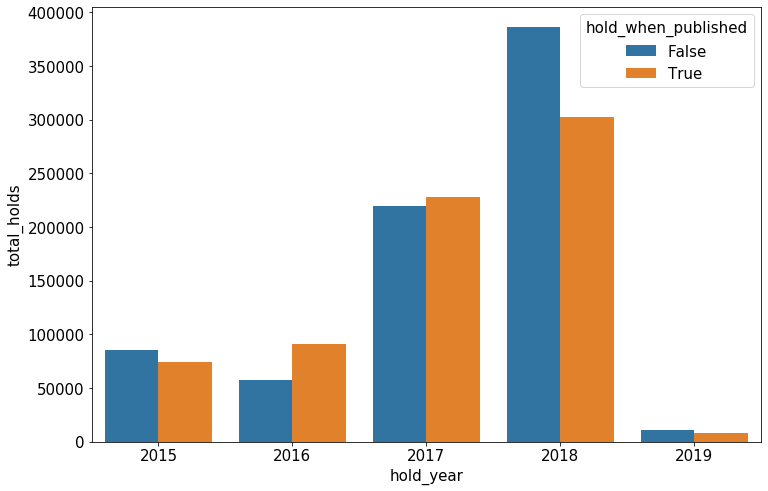

In [10]:
pubs = data.loc[:, ['branch_id', 'branch_name', 'holds', 'hold_year', 'publishing_Date']]
pubs.loc[:,'hold_when_published'] = pubs.hold_year == pubs.publishing_Date

pubs_g = pubs.groupby(['hold_year', 'hold_when_published']).agg(total_holds=('holds', 'sum'))
pubs_g = pubs_g.reset_index()

sns.barplot(x='hold_year', y='total_holds', hue='hold_when_published', data=pubs_g)

plt.savefig('imgs/pubs.png', bbox_inches="tight")

It seems that novelty is a trend that comes and goes. It was ignited in 2016 and 2017, but in 2018 the preference went back to books published in previous years, rather than brand published books.

Let's try to see the picture branch wise:

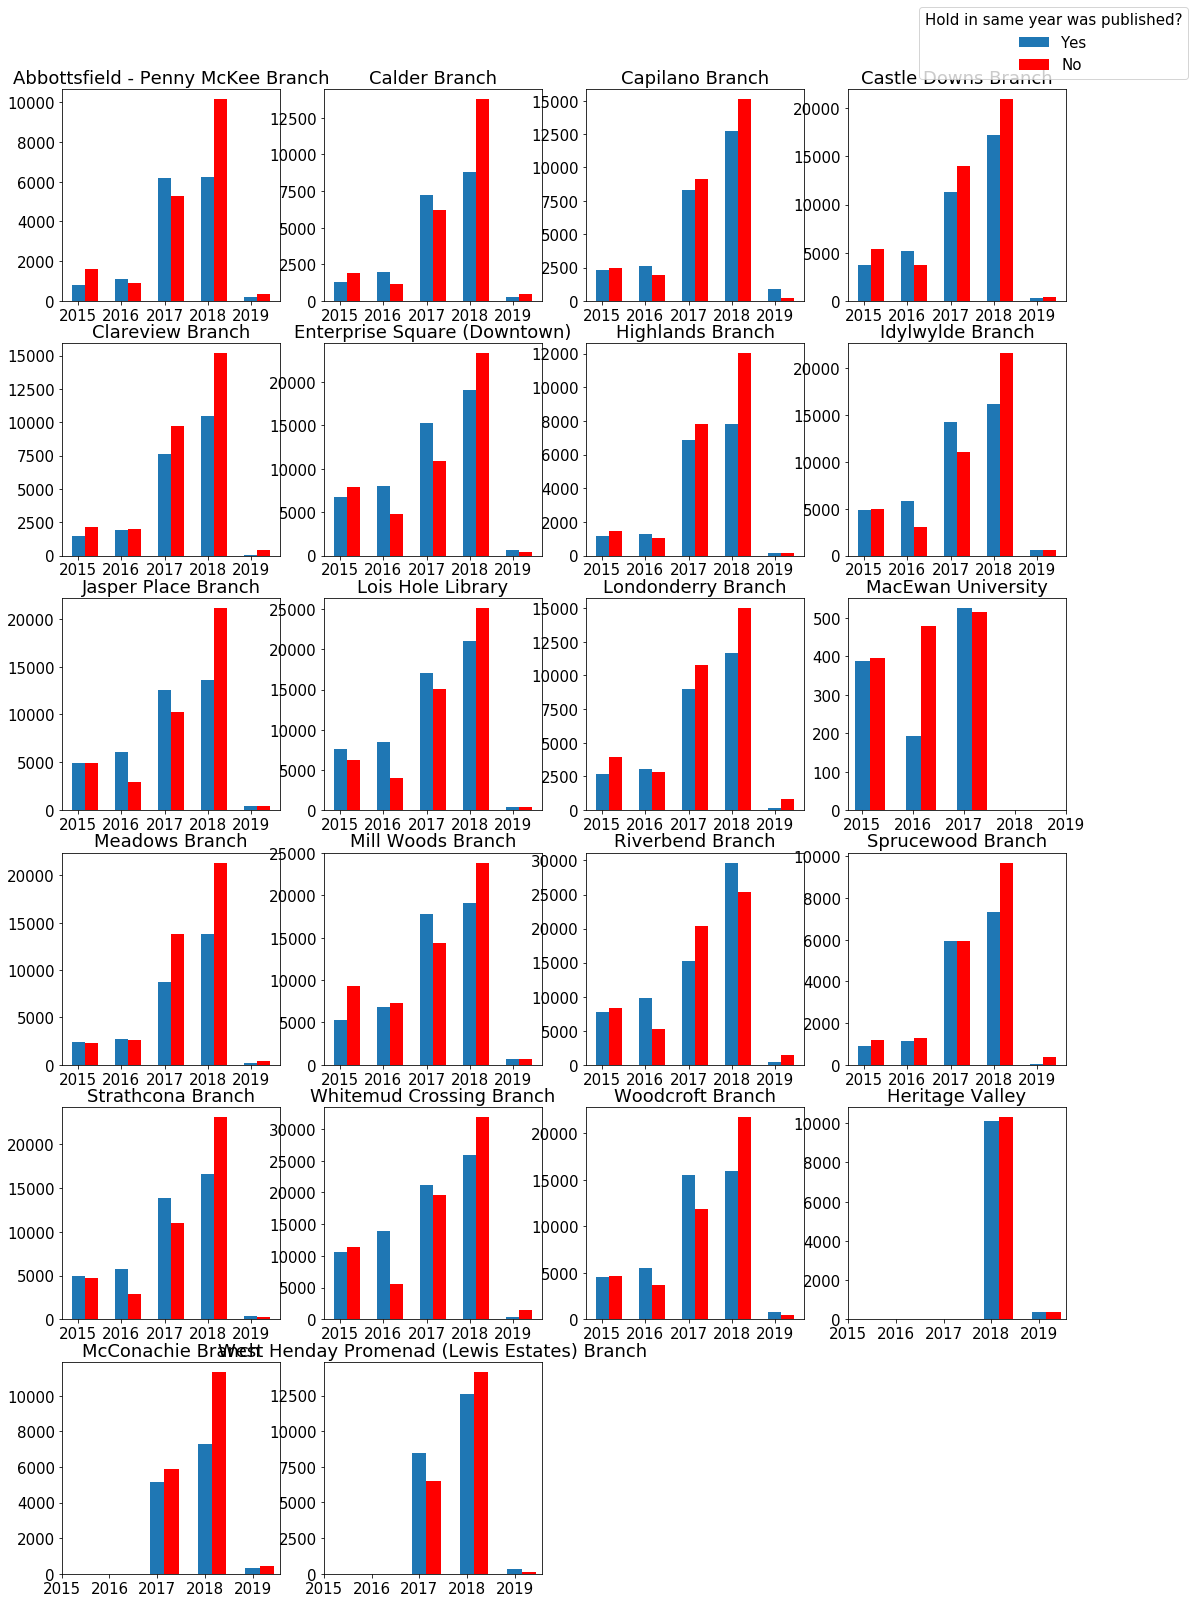

In [11]:
pubs_gb = pubs.groupby(['hold_year', 'branch_name', 'hold_when_published']).agg(total_holds=('holds', 'sum'))

pubs_gb = pubs_gb.reset_index()

years = [2015, 2016, 2017, 2018, 2019] # lets leave 019 once that it is an incomplete year - informartion wise
branches = list(pubs_gb.branch_name.unique())

ncol = 4
nrow = 6
fig2, ax2 = plt.subplots(nrow, ncol, figsize=(18,25))

width = 0.3
row = 0
col = 0
for count,branch in zip(range(ncol*nrow),branches): 
    if col == 4:
        col = 0
        row+=1
    hb = pubs_gb[pubs_gb.branch_name==branch]
    hb_t = hb[hb.hold_when_published == True]
    hb_f = hb[hb.hold_when_published == False]
    ax2[row,col].bar(hb_t.hold_year, hb_t.total_holds,width, label='True')
    ax2[row,col].bar(hb_f.hold_year+width, hb_f.total_holds,width, color='red', label='False')
    ax2[row,col].title.set_text(branch)
    ax2[row,col].set_xticks(years)
    col += 1
                    
fig2.legend(labels=['Yes', 'No'], loc='upper right', title='Hold in same year was published?' )
plt.subplots_adjust(top=0.95)
plt.title('Number of holds per year - per branch')

ax2[-1,-1].set_visible(False)
ax2[-1,-2].set_visible(False)

We can see that there are branches trending towards recent published books, while others are trending in the other way - or even oscillating between the two.

#### All time geo exploration

In [12]:
pub_geototal = pubs.groupby(['branch_id','hold_when_published']).agg(total_holds=('holds', 'sum'))
pub_geototal.loc[:,'%_holds'] = 0
pub_geototal.loc[:,'publishing_preference'] = ''

#create dataset with newer, neutral, older labels
brchs = list(pub_geototal.index.unique('branch_id'))
boo = [True, False]
for branch in brchs:
    branch_total = pub_geototal.loc[branch,'total_holds'].sum()
    for bol in boo:
        val = pub_geototal.loc[(branch,bol), 'total_holds']
        pub_geototal.loc[(branch,bol),'%_holds'] = val/branch_total
    
    # for a certain bias tower newer or older I was initially looking for values >= than 0.60
    # but it seems we cannot conclude anything for this case so we are going to use 0.55
    
    true_p = pub_geototal.loc[(branch,True), '%_holds']
    if true_p >= 0.55:
        pub_geototal.loc[(branch,True),'publishing_preference'] = 'Newer'
    elif true_p>0.45 and true_p<0.55:
        pub_geototal.loc[(branch,True),'publishing_preference'] = 'Neutral'
    else:
        pub_geototal.loc[(branch,True),'publishing_preference'] = 'Older'
        
pub_geototal = pub_geototal[pub_geototal['publishing_preference']!=''].reset_index()

#merge de coordinates
pub_geomerged = pub_geototal.merge(branch_info, how='left', left_on='branch_id', right_on='Branch ID')

#plot graph

# marker_c = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
#             'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
#             'darkpurple', 'pink', 'lightblue', 'lightgreen', 
#             'gray', 'black', 'lightgray']

pub_colors = {
    'Newer': 'blue',
    'Neutral': 'gray',
    'Older': 'red'
}

m_pub = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)

for index, row in pub_geomerged.iterrows():
    folium.CircleMarker([row['Latitude'], row['Longitude']],
                                    radius = 10,
                                    color = 'gray',
                                    fill=True,
                                    fill_opacity=0.9,
                                    fill_color=pub_colors[row['publishing_preference']],
                                    tooltip= row['Branch'],
                                   ).add_to(m_pub)

legend_html_pub =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b> Map Legend  </b> <br>
                            &nbsp; Newer &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                            &nbsp; Neutral &nbsp; <i class="fa fa-map-marker fa-2x" style="color:gray"></i><br>
                            &nbsp; Older &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                              </i>
                </div>
                ''' 

m_pub.get_root().html.add_child(folium.Element(legend_html_pub))
m_pub

What about during the years?

In [13]:
# Crafting the dataset with years
pub_geoyear = pubs.groupby(['hold_year', 'branch_id','hold_when_published']).agg(total_holds=('holds', 'sum'))
pub_geoyear.loc[:,'%_holds'] = 0
pub_geoyear.loc[:,'publishing_preference'] = ''

#create dataset with newer, neutral, older labels
brchs2 = list(pub_geoyear.index.unique('branch_id'))
years_p = list(pub_geoyear.index.unique('hold_year'))
boo = [True, False]

for year in years_p:
    for branch in brchs2:
        try:
            branch_total = pub_geoyear.loc[(year,branch),'total_holds'].sum()
            for bol in boo:
                val = pub_geoyear.loc[(year,branch,bol), 'total_holds']
                pub_geoyear.loc[(year,branch,bol),'%_holds'] = val/branch_total

            # for a certain bias tower newer or older lets try 60% minimum

            true_p = pub_geoyear.loc[(year,branch,True), '%_holds']
            if true_p >= 0.6:
                pub_geoyear.loc[(year, branch,True),'publishing_preference'] = 'Newer'
            elif true_p>0.4 and true_p<0.6:
                pub_geoyear.loc[(year, branch,True),'publishing_preference'] = 'Neutral'
            else:
                pub_geoyear.loc[(year, branch,True),'publishing_preference'] = 'Older'
        except KeyError:
            continue
pub_geoyear = pub_geoyear[pub_geoyear['publishing_preference']!=''].reset_index()

pub_geoyear

#merge de coordinates
pub_geoyear_m = pub_geoyear.merge(branch_info, how='left', left_on='branch_id', right_on='Branch ID')
pub_geoyear_m.head()

,hold_year,branch_id,hold_when_published,total_holds,%_holds,publishing_preference,Branch ID,Branch,Address,Latitude,Longitude
0,2015,EPLABB,True,812,0.335676,Older,EPLABB,Abbottsfield - Penny McKee,3410 - 118 Avenue,53.570451,-113.391518
1,2015,EPLCAL,True,1318,0.410592,Neutral,EPLCAL,Calder,12710 - 131 Avenue NW,53.590515,-113.542369
2,2015,EPLCLV,True,1472,0.404729,Neutral,EPLCLV,Clareview,3808 - 139 Avenue,53.601302,-113.401769
3,2015,EPLCPL,True,2329,0.482594,Neutral,EPLCPL,Capilano,9915 - 67 Street,53.537896,-113.419927
4,2015,EPLCSD,True,3753,0.410792,Neutral,EPLCSD,Castle Downs,"106 Lakeside Landing, 15379 Castle Downs Rd",53.615736,-113.516633


In [14]:
@interact(year = widgets.IntSlider(min=2015, max=2019, step=1, value=2015))
def generate_geo_pub(year=[2015, 2016, 2017, 2018, 2019]):
    '''Generate Geo Map with round markers with publishing proference in each branch
       Represents sucesses by year in number of hold
       
       year = integer, year you would like to analyze
        '''
    m_pub_y = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)
    
    data_pub = pub_geoyear_m[pub_geoyear_m.hold_year==year]
    
    for index, row in data_pub.iterrows():
        folium.CircleMarker([row['Latitude'], row['Longitude']],
                                    radius = 10,
                                    color = 'gray',
                                    fill=True,
                                    fill_opacity=0.9,
                                    fill_color=pub_colors[row['publishing_preference']],
                                    tooltip= row['Branch'],
                                   ).add_to(m_pub_y)

    legend_html_pub =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b> Map Legend  </b> <br>
                            &nbsp; Newer &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                            &nbsp; Neutral &nbsp; <i class="fa fa-map-marker fa-2x" style="color:gray"></i><br>
                            &nbsp; Older &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                              </i>
                </div>
                ''' 

    m_pub_y.get_root().html.add_child(folium.Element(legend_html_pub))
    
    return m_pub_y   

interactive(children=(IntSlider(value=2015, description='year', max=2019, min=2015), Output()), _dom_classes=(…

Overall I would not say that the publishing dates have a profound influence in the **all time total amounts of holdings**, once that the %s are close to 55-45%, which are not very satisfactory  to take any conclusion.

Looking the yearly fluctuations we seem to have quite the same scenario, although in 2018 we see a more prominent trend towards oldest books than newest ones.

### - 'Can we conclude anything using the google books rating??' 

As I could seen and the data preparation phase (in another notebook, check the [github](https://github.com/FernandoMeiraFilho/Edmonton-Library-EDA) if you want to see it), the google rating info is missing in approximately 25% of the lines of the dataset. 

Let's check if this affect a bigger part of the holds -so it would compromise out capacity to take some conclusion using this information - .

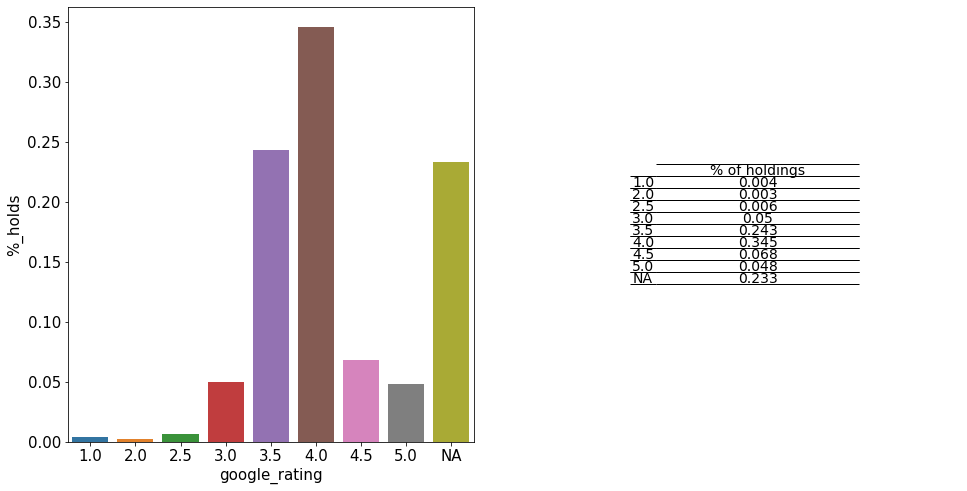

In [15]:
grating = data.loc[:,['hold_year', 'holds', 'google_rating']].fillna('NA')
grating_g = grating.groupby(['google_rating']).agg(total_holds=('holds', 'sum'))
grating_g['%_holds'] = grating_g.loc[:,'total_holds'] / grating_g.loc[:,'total_holds'].sum()
grating_g = grating_g.reset_index()#.sort_values('%_holds')

figR, axR = plt.subplots(1,2, figsize=(16,8))

ratings = list(grating_g.google_rating.unique())
rlabel = [str(rat) for rat in ratings]
vals = [[str(round(value,3))] for index,value in grating_g['%_holds'].iteritems()]

sns.barplot(x='google_rating', y='%_holds', data=grating_g, ax=axR[0])
axR[1].axis('tight')
axR[1].axis('off')
axR[1].table(cellText=vals, rowLabels=rlabel, colLabels=['% of holdings'],loc='center', 
             cellLoc='center', colWidths=[0.5], edges='horizontal').set_fontsize(14)


So, as we could see concerning the number of lines, the scenario here for the number of holds ins quite the same. We have **23%** of the number of holds with NA values.

Anyway, it is interesting to note that the bulk of the holdings are gravitating towards the 3.5 and 4.0 rating. 

### The size effect

Before we dig into the study of the successes, let's understand more the dynamics of the branch size - in holding power.


In [16]:
size = data.loc[:,['branch_name', 'holds', 'hold_year']]
size_g = size.groupby(['branch_name','hold_year']).agg(total_holds=('holds', 'sum'))
size_g = size_g.unstack(1).fillna(0)

#creating total columns
size_g['total_sum'] = size_g.sum(axis=1)
size_g['total_mean'] = size_g.mean(axis=1)
size_g['total_median'] = size_g.median(axis=1)

#creating size rank column
nbs = len(size_g.index)
size_g = size_g.sort_values('total_sum')
size_g['size_rank'] = sorted(list(range(1,nbs+1)))
size_g = size_g.sort_values('total_sum', ascending=False)

#creating % column
totalg = size_g.loc[:,'total_sum'].sum(0)
size_g['%holds'] = (size_g.loc[:,'total_sum'] / totalg ) * 100

topgs = [5, 10, 15]

for top in topgs:
    total_top = round(size_g.iloc[:top, 9].sum(),1)
    print('The top {} branchs in holdings have {}% of the total number.'.format(top,total_top))


size_g.iloc[:,5:]#.to_html()

The top 5 branchs in holdings have 39.1% of the total number.
The top 10 branchs in holdings have 67.2% of the total number.
The top 15 branchs in holdings have 86.1% of the total number.


,total_sum,total_mean,total_median,size_rank,%holds
hold_year,,,,,
branch_name,,,,,
Whitemud Crossing Branch,141714.0,47238.000000,40650.000000,22,9.681155
Riverbend Branch,123651.0,41217.000000,35626.000000,21,8.447186
Lois Hole Library,105351.0,35117.000000,32087.000000,20,7.197026
Mill Woods Branch,105079.0,35026.333333,32192.000000,19,7.178444
Enterprise Square (Downtown),96716.0,32238.666667,26129.000000,18,6.607128
Woodcroft Branch,84589.0,28196.333333,27392.000000,17,5.778675
Strathcona Branch,83448.0,27816.000000,24838.000000,16,5.700728
Idylwylde Branch,82838.0,27612.666667,25215.000000,15,5.659056


In [17]:
plt.rcParams.update({'font.size': 16})

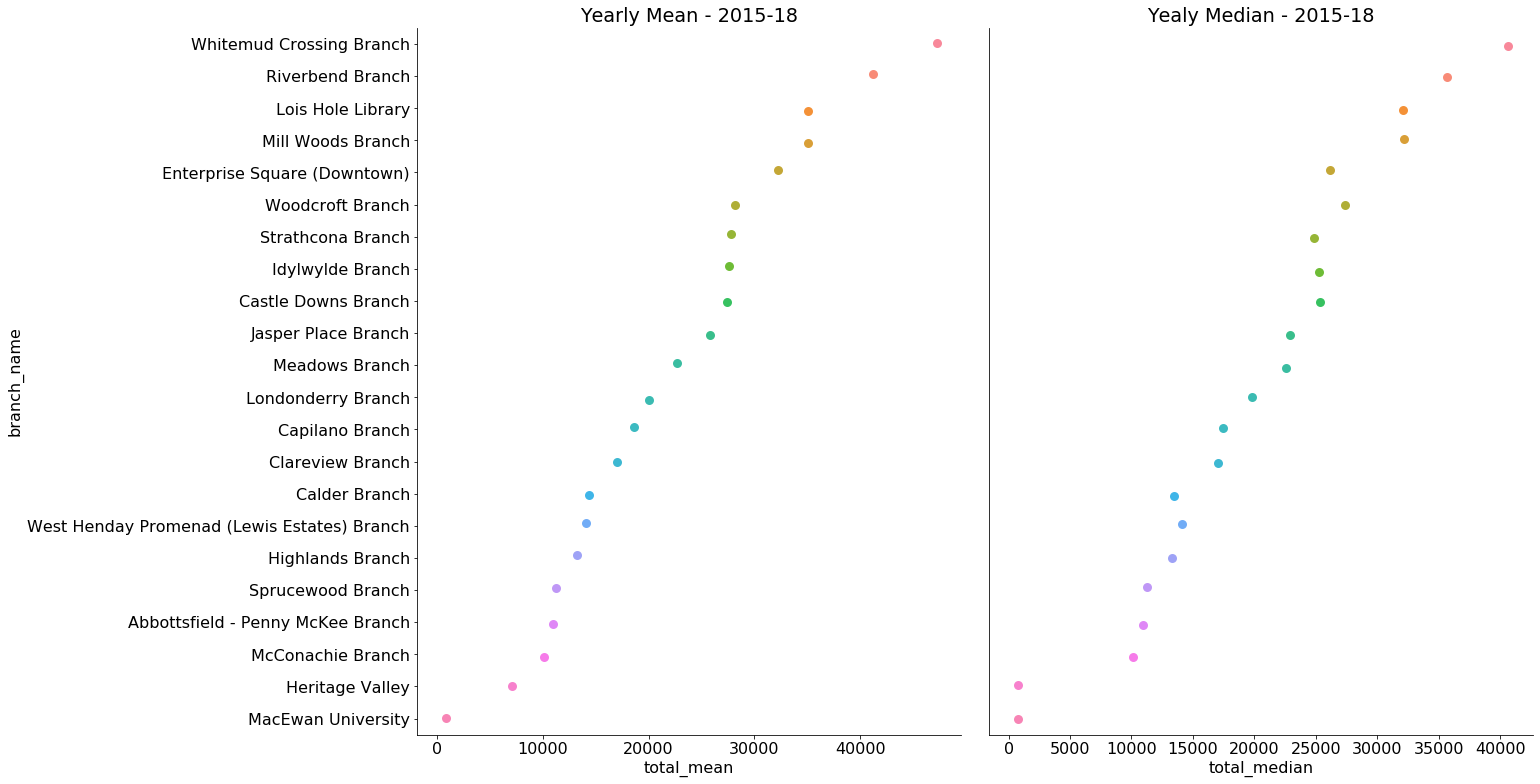

In [18]:
fig4, ax4 = plt.subplots(1,2, figsize=(20,13), sharey=True)

sns.stripplot(x=size_g['total_mean'], y=size_g.index,size=9, ax=ax4[0])
ax4[0].title.set_text('Yearly Mean - 2015-18')
sns.stripplot(x=size_g['total_median'], y=size_g.index,size=9, ax=ax4[1])
ax4[1].title.set_text('Yealy Median - 2015-18')
ax4[1].get_yaxis().set_visible(False)

plt.subplots_adjust(wspace=0.05)
sns.despine()

plt.savefig('imgs/b_means.png', bbox_inches="tight")

p-value for normatest : 0.7909546661512719


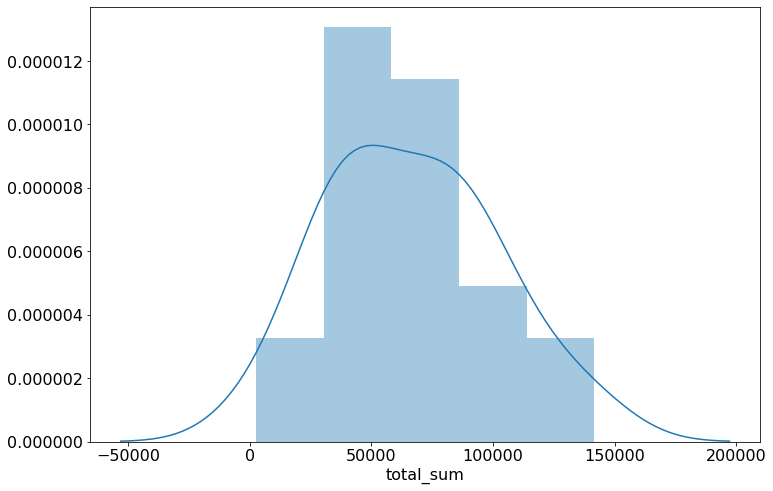

In [19]:
t, p_hold = stats.kurtosistest(size_g['total_sum'], axis=None)

print('p-value for normatest : {}'.format(p_hold))

sns.distplot(size_g['total_sum'])

plt.savefig('imgs/hold_hist.png')

Even though the distribution for the total holds is not normal (as the kurtosis test indicates), we have can say that we don't have an extreme skewed situation so it would effects our futures analysis further along, but it should be healthy to keep an eye and plot comparisons or use branch ranks to see a possible influention by bigger branches.

### Exploring Genres

First things first, what are our all time champions for genre?

In [20]:
genr = data.loc[:,['genre', 'holds', 'hold_year', 'branch_name']]
genr_g = genr.groupby('genre').agg(total_holds=('holds','sum')).sort_values('total_holds', ascending=False)

#getting total percentages
total = genr_g.loc[:,'total_holds'].sum()
genr_g['%total'] = (genr_g['total_holds']/total)*100

#taking a look at the top 10
genr_g.head(10)

,total_holds,%total
genre,,
Fiction,783369,53.537665
Juvenile Fiction,103957,7.104717
Biography & Autobiography,100739,6.884790
Cooking,70164,4.795207
Self-Help,56262,3.845105
Young Adult Fiction,45478,3.108096
Psychology,34363,2.348465
House & Home,27254,1.862616
Business,25324,1.730714


It looks like we have 3 different types of fiction genres, we could consolidate them under Fiction and try to see what else it brings to us

In [21]:
#correction dict
corr_dict = {
    'Juvenile Fiction' : 'Fiction',
    'Young Adult Fiction': 'Fiction'
}

#lets correct on data (so it will impact further analysis and extractions)
data.genre = data.genre.apply(lambda g: corr_dict[g] if g in corr_dict.keys() else g)


genr = data.loc[:,['genre', 'holds', 'hold_year', 'branch_name']]
genr_g = genr.groupby('genre').agg(total_holds=('holds','sum')).sort_values('total_holds', ascending=False)

#getting total percentages
total = genr_g.loc[:,'total_holds'].sum()
genr_g['%total'] = (genr_g['total_holds']/total)*100

#taking a look at the top 10
print('Top 10 genres % in total holdings:{}'.format(genr_g['%total'].head(10).sum()))
genr_g.head(10)#.to_html()

Top 10 genres % in total holdings:89.88860799980317


,total_holds,%total
genre,,
Fiction,932804,63.750478
Biography & Autobiography,100739,6.884790
Cooking,70164,4.795207
Self-Help,56262,3.845105
Psychology,34363,2.348465
House & Home,27254,1.862616
Business,25324,1.730714
Health & Fitness,25217,1.723401
Foreign Language Study,23838,1.629157


 89% for the top 10! That is total domination(shout out to Fiction that, if we sum up wi 'Juvenile fiction' it is 60% of all holding). Can we see here if this was true for all the years? Is there something new coming?

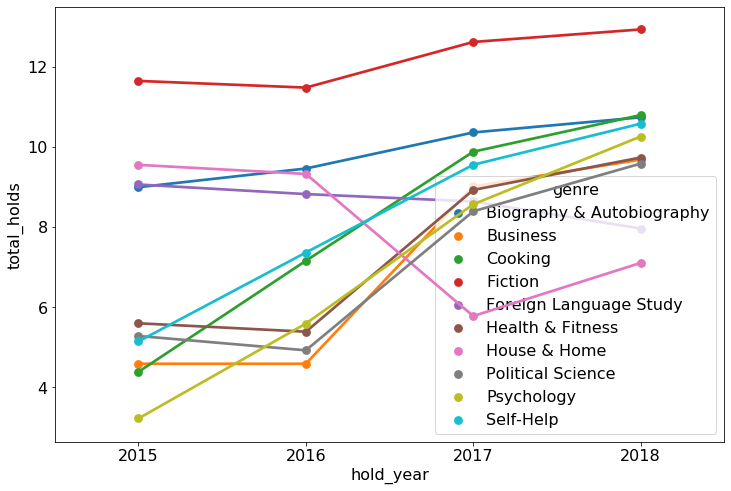

In [22]:
genr_y = genr[genr.hold_year!=2019].groupby(['hold_year','genre']).agg(total_holds=('holds','sum')).reset_index()

top10g = genr_g.index.tolist()[:10]
gen10y = genr_y[genr_y.genre.isin(top10g)]

gen10y
sns.pointplot(x=gen10y.hold_year, y=np.log(gen10y.total_holds), hue=gen10y.genre, log=True )
# plt.xticks([2015,2016,2017,2018])

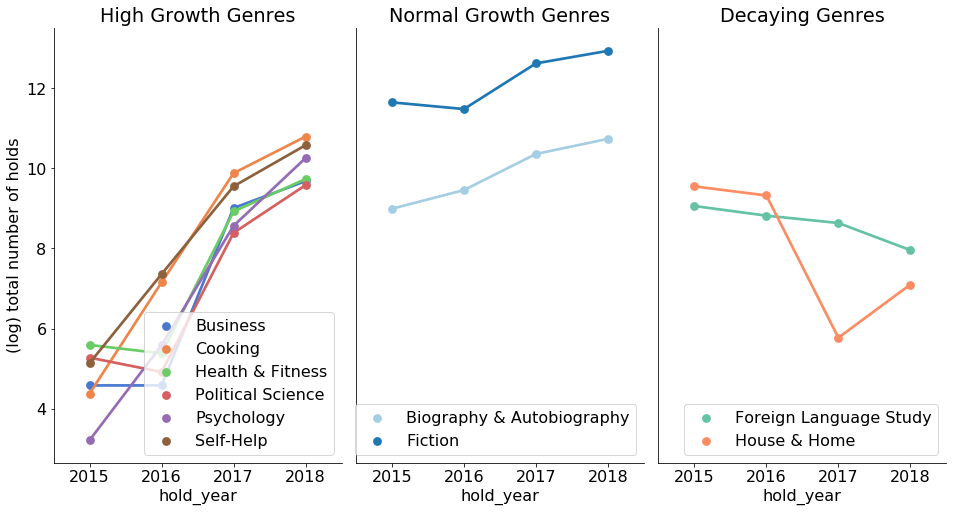

In [23]:
# separating the high growth and the stable genres in 2 plots

high_growth = ['Psychology', 'Cooking', 'Self-Help', 'Business', 'Health & Fitness', 'Political Science']
stable_growth = ['Fiction', 'Biography & Autobiography']
decaying = ['House & Home', 'Foreign Language Study']
h_set = genr_y[genr_y.genre.isin(high_growth)]
s_set = genr_y[genr_y.genre.isin(stable_growth)]
d_set = genr_y[genr_y.genre.isin(decaying)]

figG, axG = plt.subplots(1,3, figsize=(16,8), sharey=True)

sns.set_palette('muted')
sns.pointplot(x=h_set.hold_year, y=np.log(h_set.total_holds), hue=h_set.genre, ax=axG[0] )
axG[0].title.set_text('High Growth Genres')
axG[0].legend(loc='lower right')
axG[0].set_ylabel('(log) total number of holds')

sns.set_palette("Paired")
sns.pointplot(x=s_set.hold_year, y=np.log(s_set.total_holds), hue=s_set.genre, pallete='GnBu_d', ax=axG[1], )
axG[1].title.set_text('Normal Growth Genres')
axG[1].get_yaxis().set_visible(False)
axG[1].legend(loc='lower right')

sns.set_palette("Set2")
sns.pointplot(x=d_set.hold_year, y=np.log(d_set.total_holds), hue=d_set.genre, pallete='GnBu_d', ax=axG[2], )
axG[2].title.set_text('Decaying Genres')
axG[2].get_yaxis().set_visible(False)
axG[2].legend(loc='lower right')

plt.subplots_adjust(wspace=0.05)
sns.despine()
plt.savefig('imgs/genre_3stories.png')

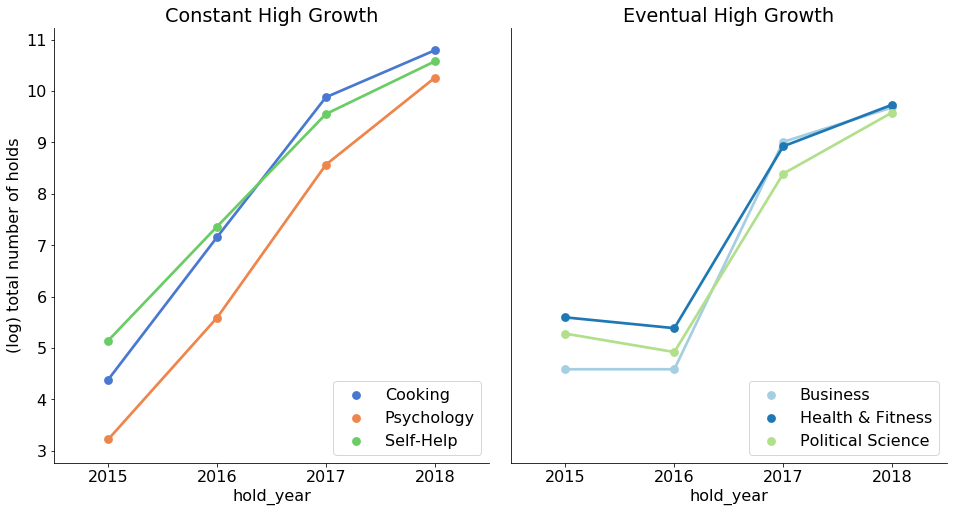

In [24]:
high_growth1 = ['Psychology', 'Cooking', 'Self-Help' ]
high_growth2 = ['Business', 'Health & Fitness','Political Science']

h1_set = genr_y[genr_y.genre.isin(high_growth1)]
h2_set = genr_y[genr_y.genre.isin(high_growth2)]

figG2, axG2 = plt.subplots(1,2, figsize=(16,8), sharey=True)

sns.set_palette('muted')
sns.pointplot(x=h1_set.hold_year, y=np.log(h1_set.total_holds), hue=h1_set.genre, ax=axG2[0] )
axG2[0].title.set_text('Constant High Growth')
axG2[0].legend(loc='lower right')
axG2[0].set_ylabel('(log) total number of holds')

sns.set_palette("Paired")
sns.pointplot(x=h2_set.hold_year, y=np.log(h2_set.total_holds), hue=h2_set.genre, pallete='GnBu_d', ax=axG2[1], )
axG2[1].title.set_text('Eventual High Growth')
axG2[1].get_yaxis().set_visible(False)
axG2[1].legend(loc='lower right')

plt.subplots_adjust(wspace=0.05)
sns.despine()
plt.savefig('imgs/genre_hgrowth.png')

So we have very interesting growth for the high growth genres, and for the stable ones, we can observe that the majority were able to sustain their high level with the exception of the House and Home - that we will investigate further in this analysis.

Is this **high growth genres** being featured in all branches? 

In [25]:
# subplot with heatmaps for each high growth - Using number of holding size rank to ordenate them
gen_heat = genr[genr.hold_year!=2019].groupby(['hold_year', 'branch_name', 'genre']).agg(total_holds=('holds', 'sum'))
gen_heat = gen_heat.reset_index('genre')

#Creating columns with % by year by branch by genre
yearsHeat = [2015, 2016, 2017, 2018]
branchHeat = genr.branch_name.unique().tolist()

gen_heat['%holds'] = 0
for year in yearsHeat:
    for branch in branchHeat:
        try:
            total = gen_heat.loc[(year,branch),'total_holds'].sum()
            gen_heat.loc[(year, branch),'%holds'] =  (gen_heat.loc[(year, branch),'total_holds'] / total)*100
        except KeyError:
            continue

gen_heat = gen_heat.reset_index()

#bringing the size_rank to check for the big branches effect
srank_dt = size_g.loc[:,['size_rank']].reset_index().stack().reset_index().drop(['level_0','hold_year'], axis=1)
gen_heat = gen_heat.merge(srank_dt, how='left', on='branch_name')
gen_heat = gen_heat.sort_values(['hold_year', 'size_rank'], ascending=False)

#Cleaning branch names to make them smaller
gen_heat['branch_name'] = gen_heat['branch_name'].apply(lambda name: name.replace(' Branch', ''))
gen_heat['branch_name'] = gen_heat['branch_name'].apply(lambda name: name.split(' (')[0])

# Creating new name to contain rank for the graphs
rnk_dt = gen_heat.loc[:,['branch_name', 'size_rank']].drop_duplicates(['branch_name'])
rank_dict = { row['branch_name']:row['size_rank'] for index, row in rnk_dt.iterrows() }
                 
gen_heat['branch-rank'] = gen_heat.branch_name.apply(lambda branch:'Rank {} - {}'.format(
                                                                                    rank_dict[branch], branch))

gen_heat.head()

,hold_year,branch_name,genre,total_holds,%holds,size_rank,branch-rank
1532,2018,Whitemud Crossing,Art,227,0.393694,22,Rank 22 - Whitemud Crossing
1533,2018,Whitemud Crossing,Biography & Autobiography,5581,9.679322,22,Rank 22 - Whitemud Crossing
1534,2018,Whitemud Crossing,"Body, Mind & Spirit",223,0.386757,22,Rank 22 - Whitemud Crossing
1535,2018,Whitemud Crossing,Business,521,0.903588,22,Rank 22 - Whitemud Crossing
1536,2018,Whitemud Crossing,Cooking,4427,7.677899,22,Rank 22 - Whitemud Crossing


In [26]:
genres_heat = sorted(gen_heat.genre.unique().tolist())

@interact
def generate_heatsns(genre = genres_heat):

    heater = gen_heat[gen_heat.genre==genre]#.sort_values
    heater_piv= heater.pivot_table(index=['size_rank', 'branch-rank'], values='%holds', columns='hold_year')
    heater_piv= heater_piv.fillna(0).sort_values('size_rank', ascending=False)
    heater_piv = heater_piv.reset_index('size_rank').drop('size_rank', axis=1)

    plt.title('{} Adoption by Branch by Year'.format(genre))
    
    plt.savefig('one_heat.png', bbox_inches="tight")
    
    return sns.heatmap(heater_piv, annot=True, cmap="YlGnBu")

interactive(children=(Dropdown(description='genre', options=('Architecture', 'Art', 'Automobile driving', 'Bio…

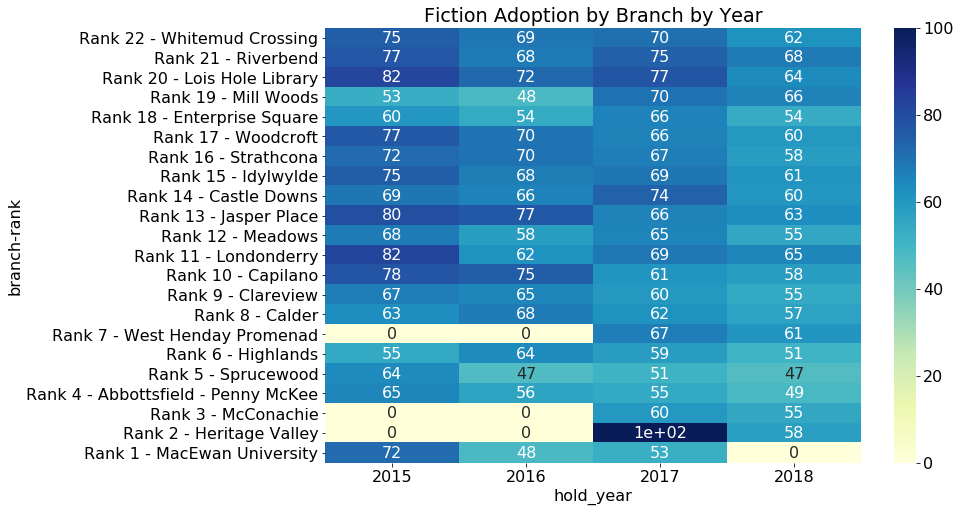

In [27]:
x = generate_heatsns('Fiction')
figX = x.get_figure()

figX.savefig('imgs/one_heat.png', bbox_inches="tight")

In [28]:
#lets try subplots to see all at once

#fixing the fucntion to generate the plots
def generate_heatmap_genre(genre, ax):
    '''
    generates a heatmap by branch and year
    genre=string
    ax = ax subplot instance
    '''

    heater = gen_heat[gen_heat.genre==genre]#.sort_values
    heater_piv= heater.pivot_table(index=['size_rank', 'branch-rank'], values='%holds', columns='hold_year')
    heater_piv= heater_piv.fillna(0).sort_values('size_rank', ascending=False)
    heater_piv = heater_piv.reset_index('size_rank').drop('size_rank', axis=1)

    ax.set_title(genre,fontweight="bold", size=25)
    ax.tick_params(labelsize=17)
    return sns.heatmap(heater_piv, annot=True, cmap="YlGnBu", ax=ax), 

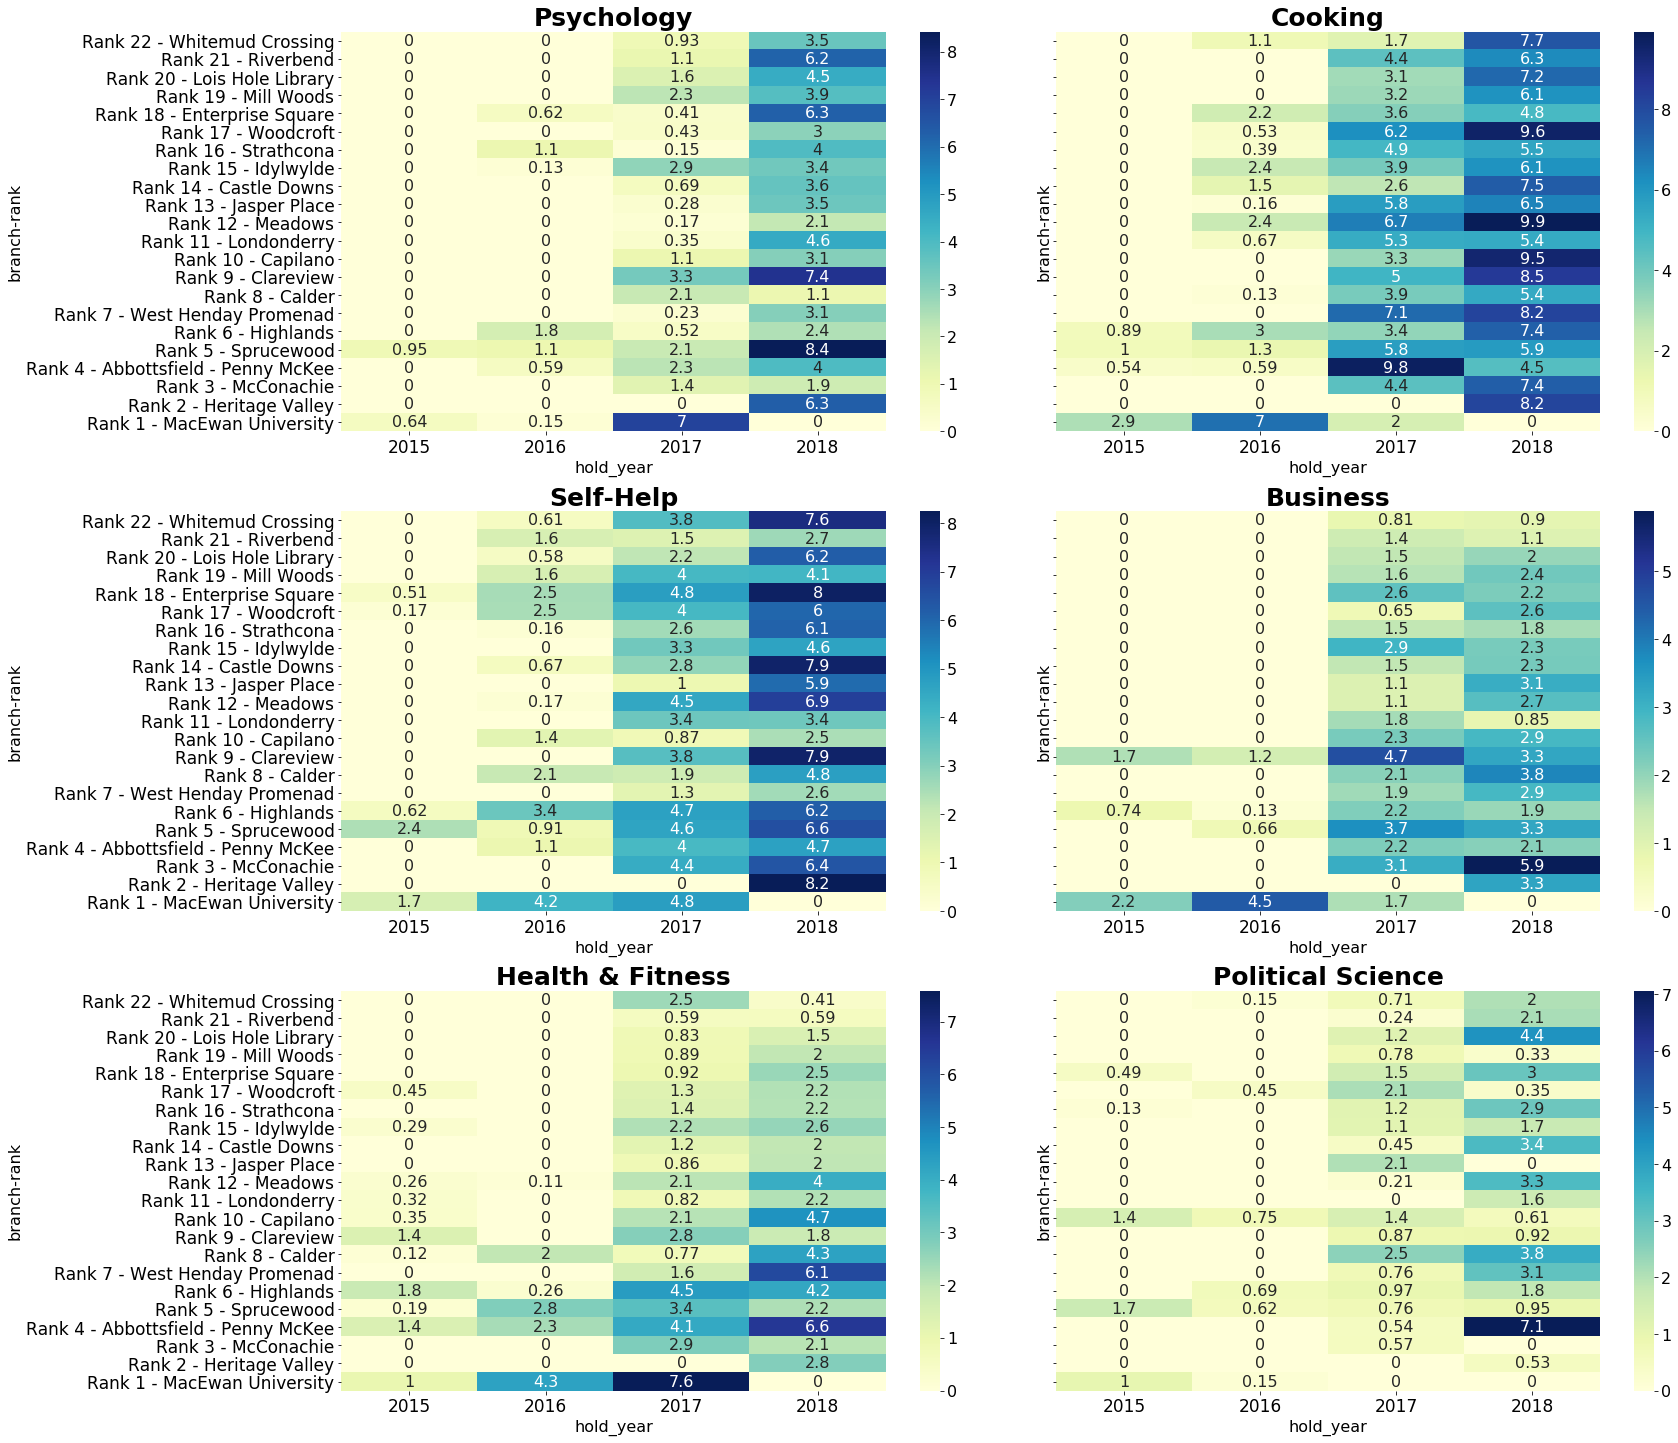

In [29]:
fig5, ax5 = plt.subplots(3,2, figsize=(25,25), sharey=True)

rowH = 0
colH = 0
for genre in high_growth:
    if colH>1:
        colH = 0
        rowH += 1
    generate_heatmap_genre(genre,ax5[rowH,colH])
    colH += 1

plt.subplots_adjust(wspace=0.05)
plt.savefig('imgs/all_heat.png', bbox_inches="tight")

#ax5[-1, -1].set_visible(False)
#plt.title('% Representation of the genre by branch and year')
#plt.savefig('heatsub.png')

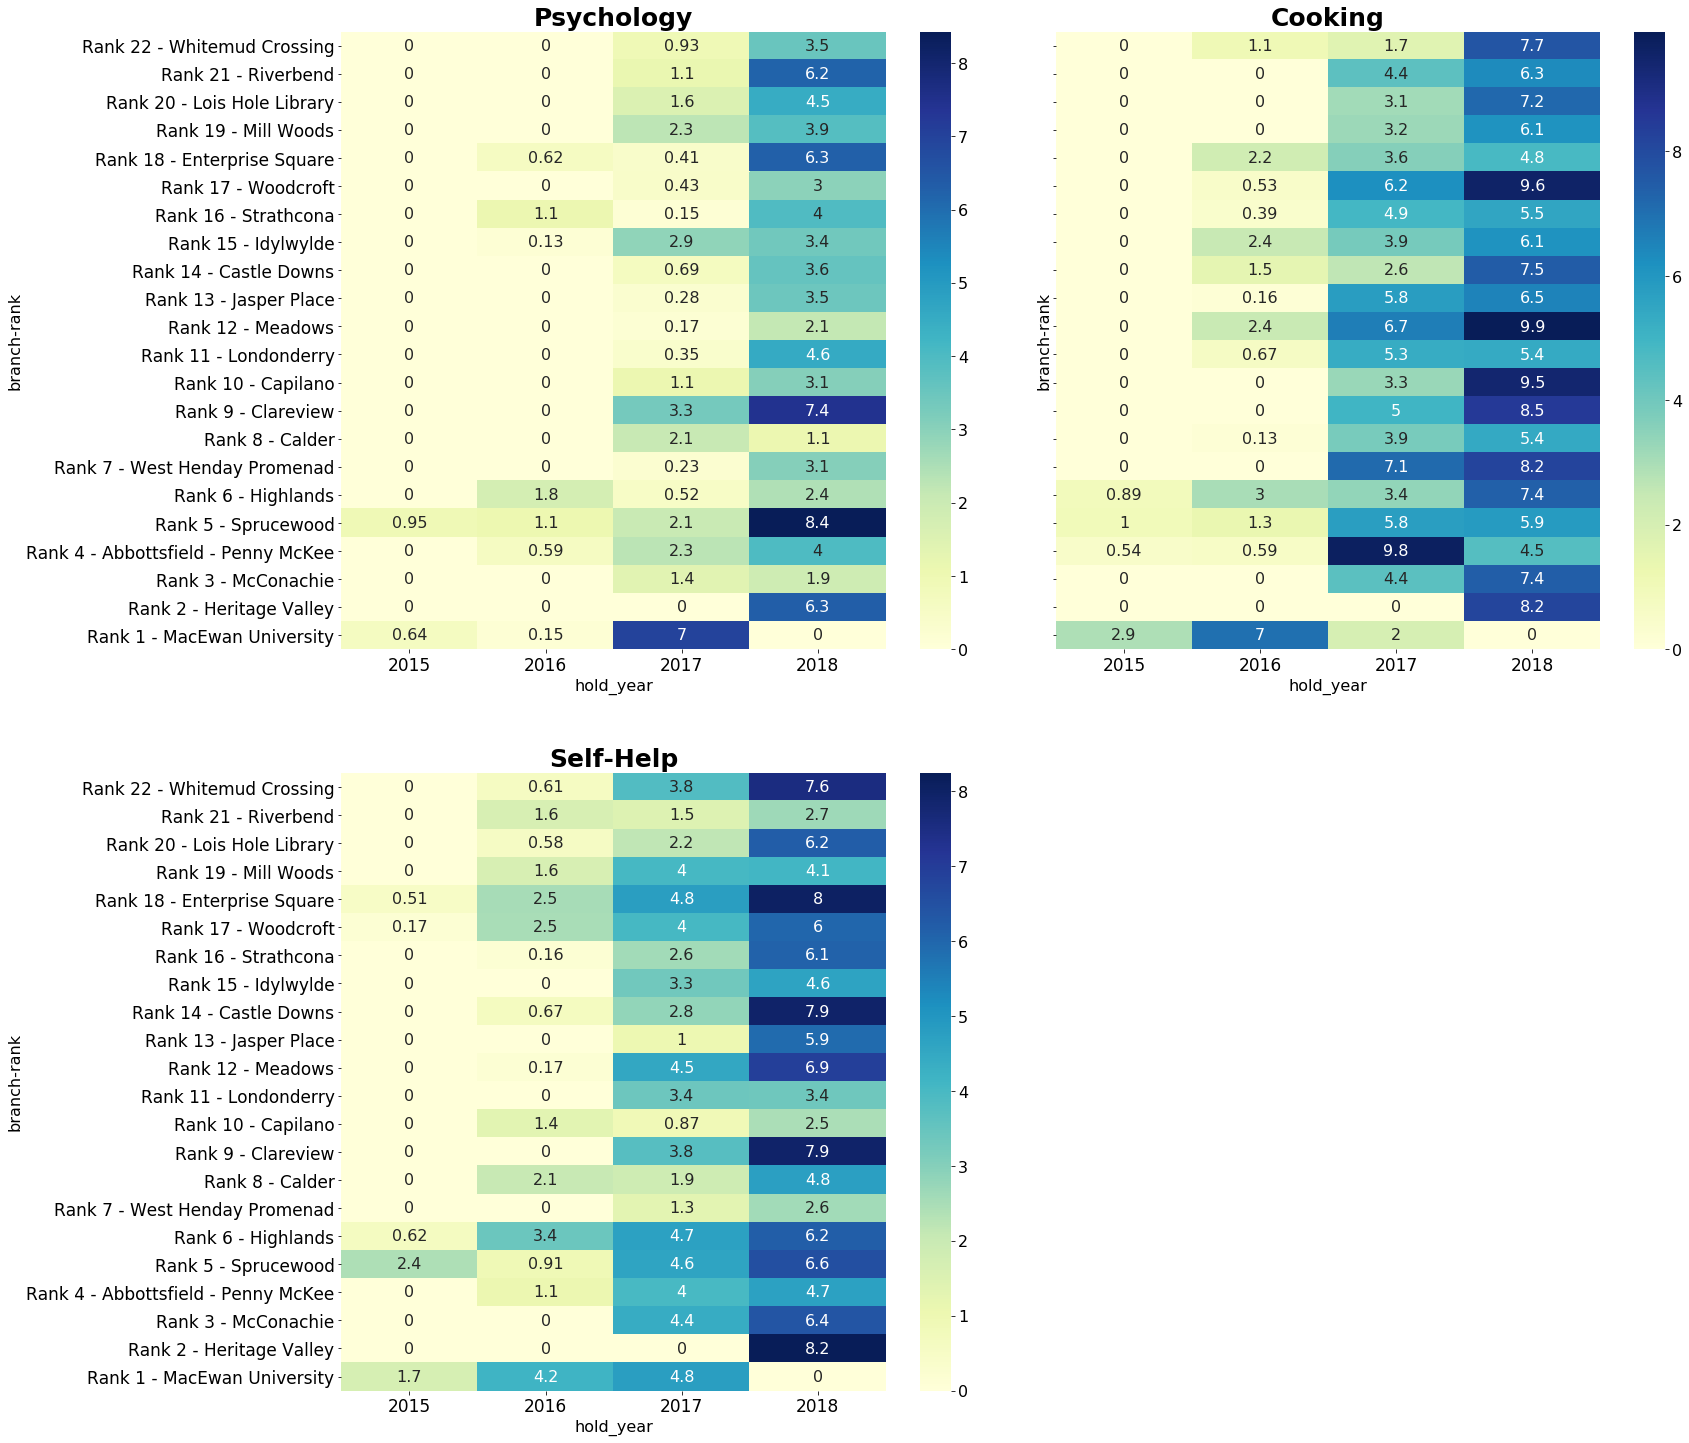

In [30]:
fig20, ax20 = plt.subplots(2,2, figsize=(25,25), sharey=True)

rowH = 0
colH = 0
for genre in high_growth1:
    if colH>1:
        colH = 0
        rowH += 1
    generate_heatmap_genre(genre,ax20[rowH,colH])
    colH += 1

plt.subplots_adjust(wspace=0.05)
ax20[-1, -1].set_visible(False)

plt.savefig('imgs/high_heat1.png', bbox_inches="tight")


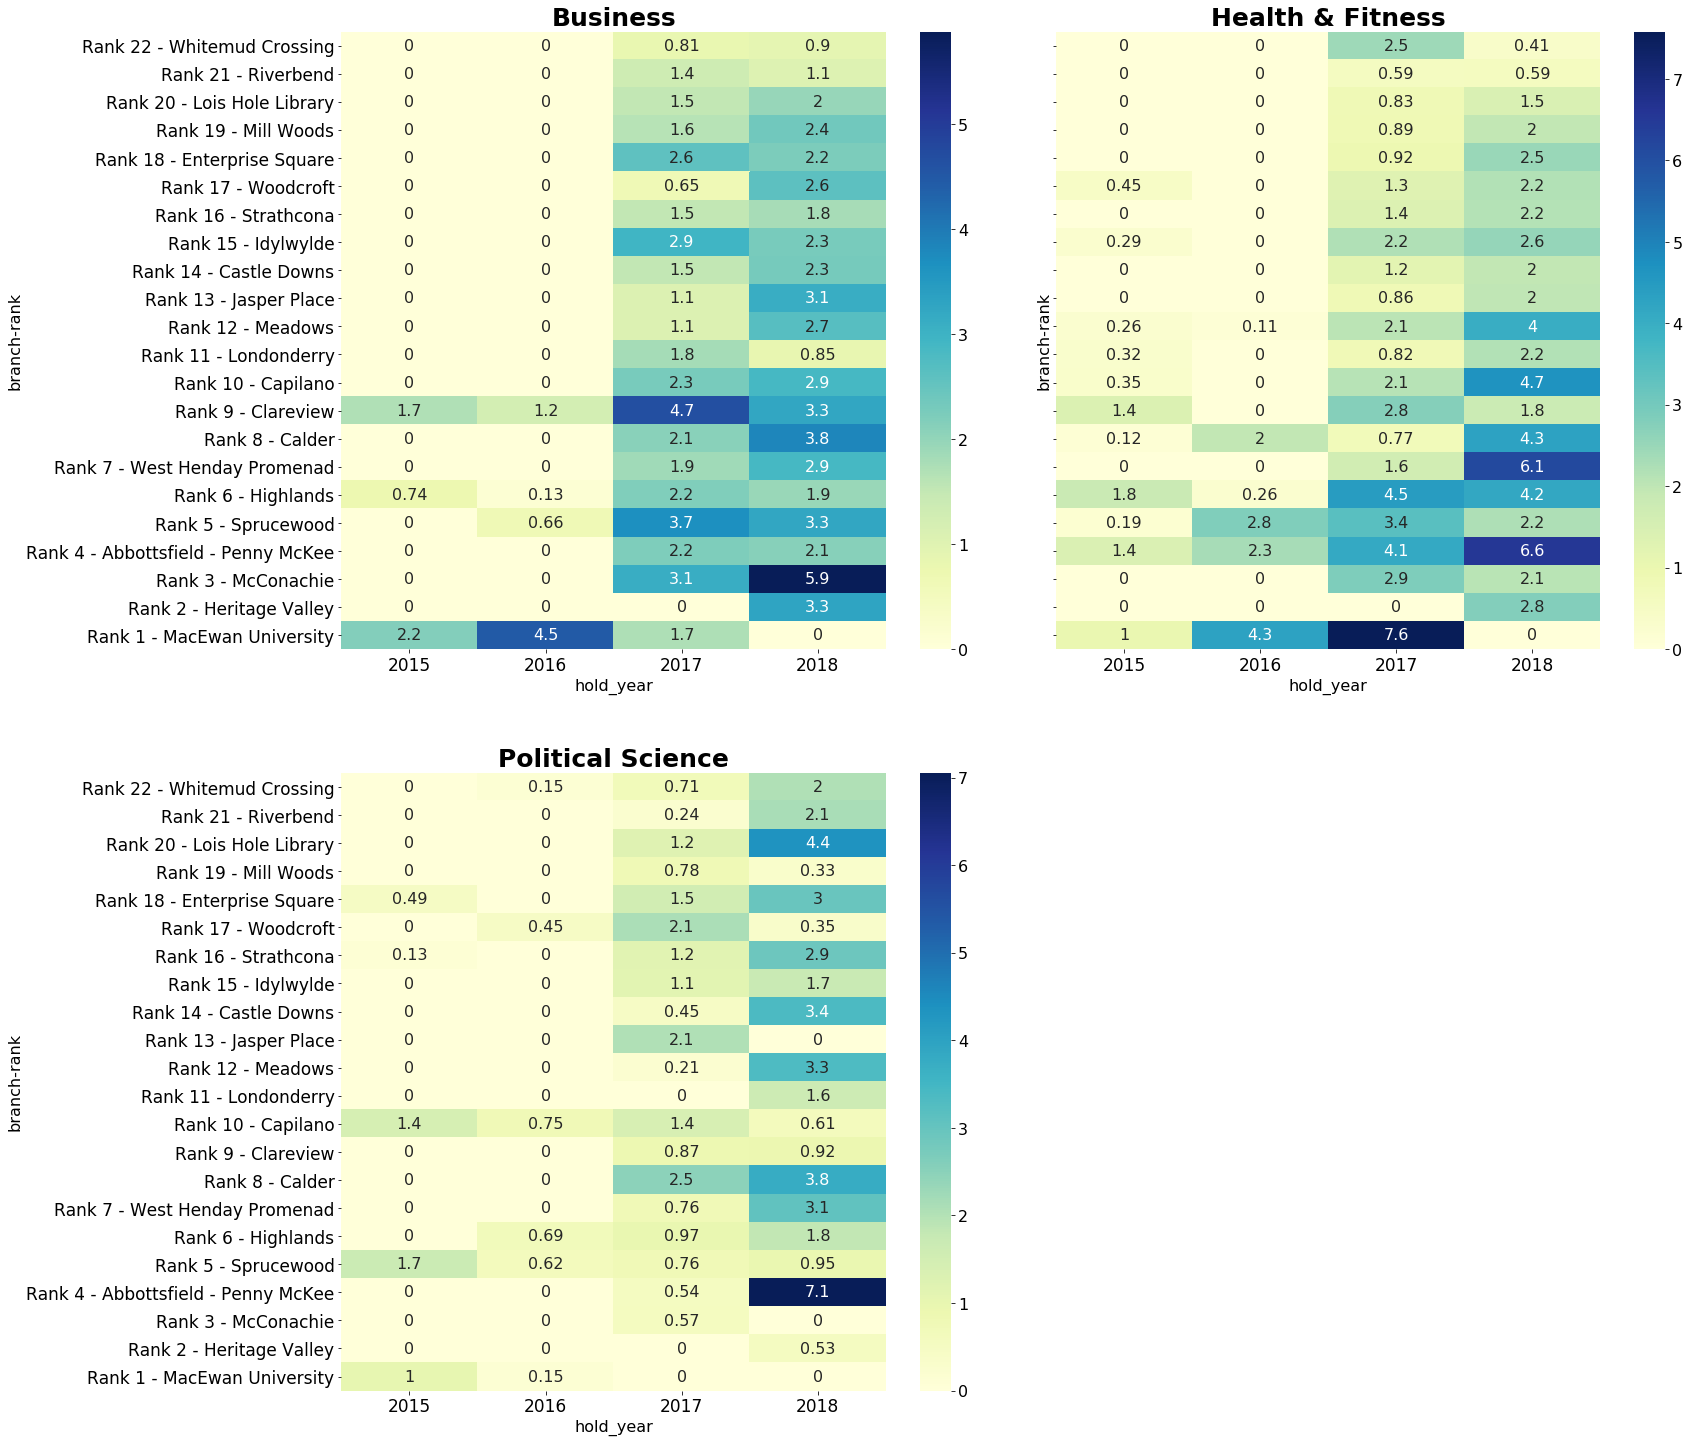

In [31]:
fig21, ax21 = plt.subplots(2,2, figsize=(25,25), sharey=True)

rowH = 0
colH = 0
for genre in high_growth2:
    if colH>1:
        colH = 0
        rowH += 1
    generate_heatmap_genre(genre,ax21[rowH,colH])
    colH += 1

plt.subplots_adjust(wspace=0.05)
ax21[-1, -1].set_visible(False)

plt.savefig('imgs/high_heat2.png', bbox_inches="tight")

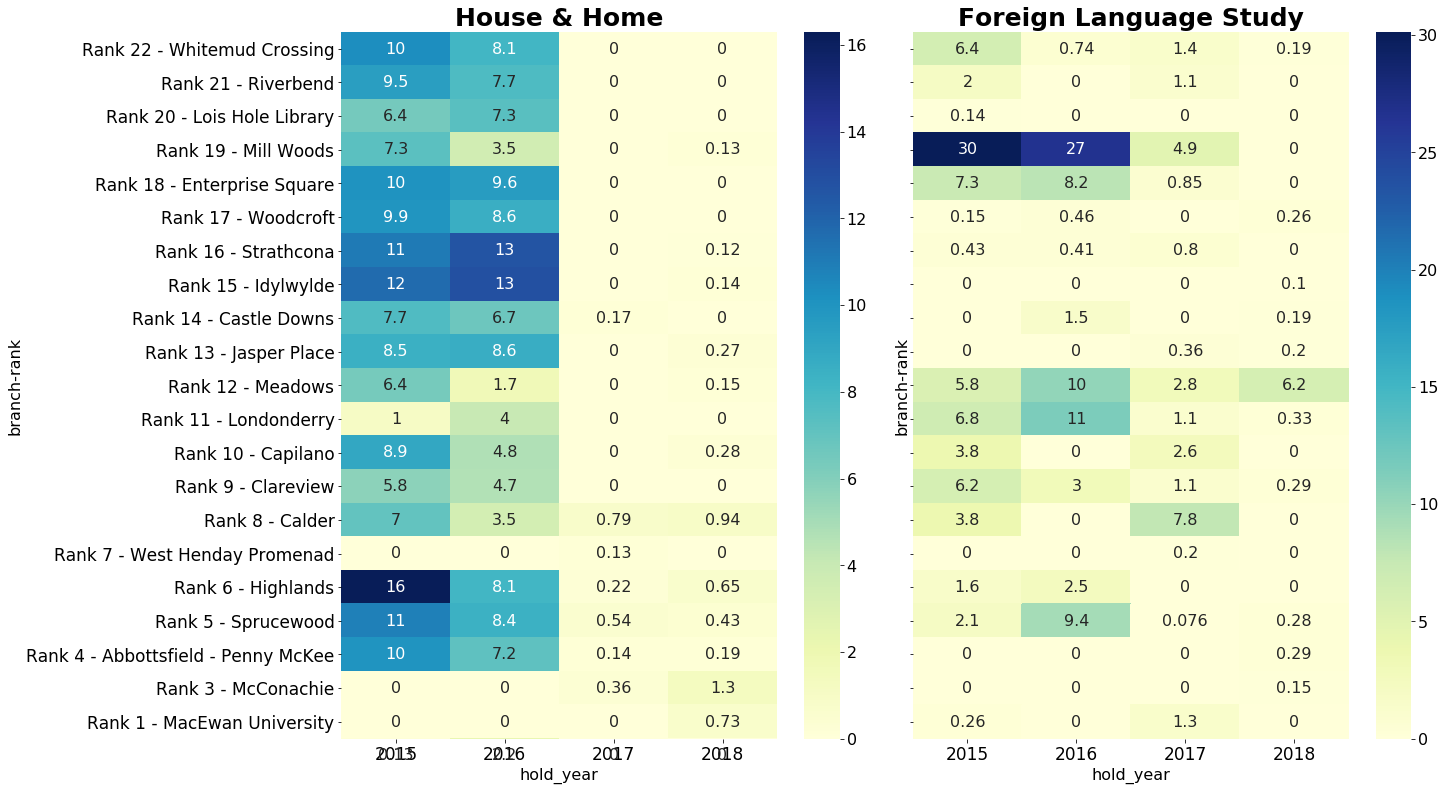

In [32]:
fig30, ax30 = plt.subplots(1,2, figsize=(20,13), sharey=True)

rowH = 0
colH = 0
for genre in decaying:
    generate_heatmap_genre(genre,ax30[colH])
    colH += 1

plt.subplots_adjust(wspace=0.05)

plt.savefig('imgs/low_heat.png', bbox_inches="tight")



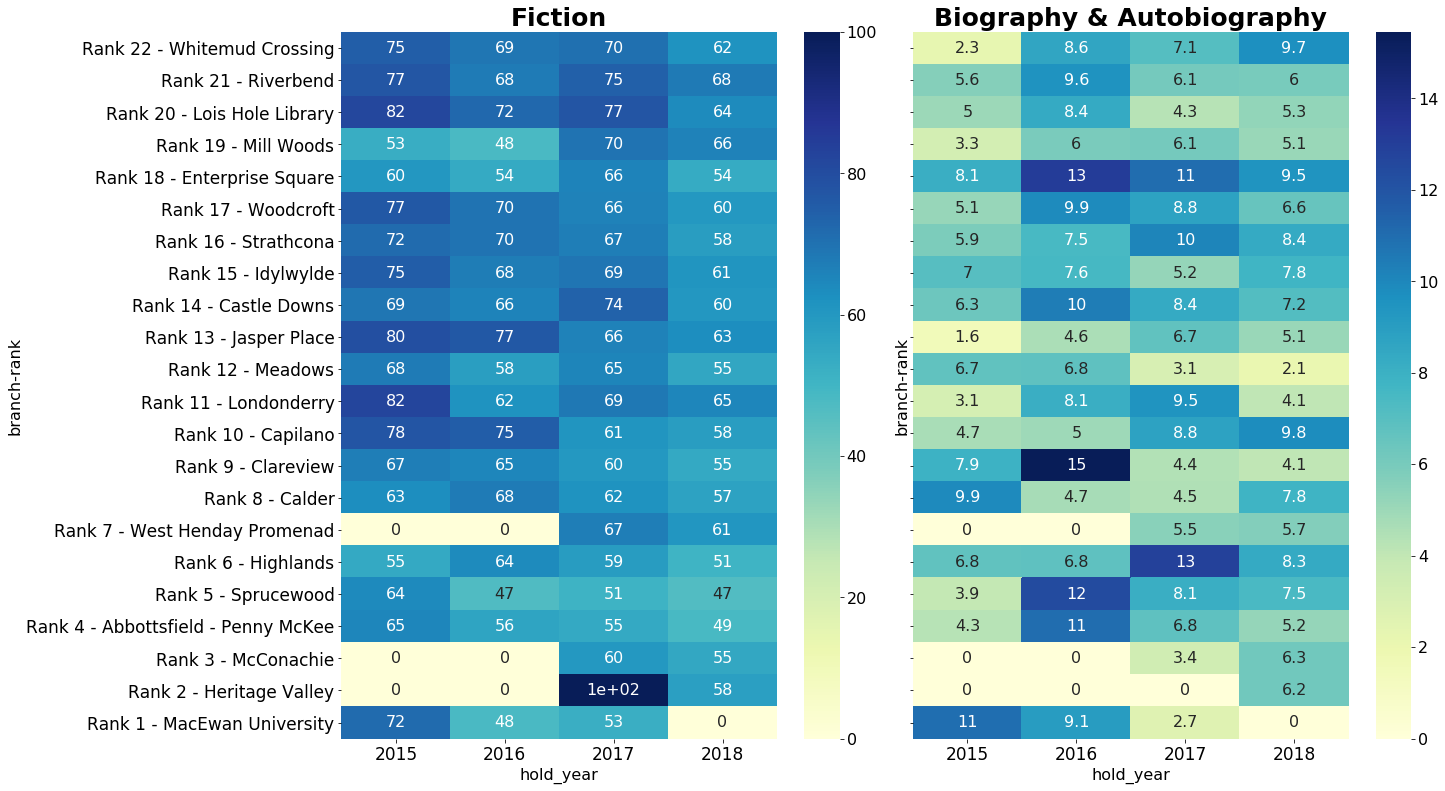

In [33]:
fig31, ax31 = plt.subplots(1,2, figsize=(20,13), sharey=True)

rowH = 0
colH = 0
for genre in stable_growth:
    generate_heatmap_genre(genre,ax31[colH])
    colH += 1

plt.subplots_adjust(wspace=0.05)

plt.savefig('imgs/stable_heat.png', bbox_inches="tight")

Are there any particular books responsible for this?

In [34]:
#lets work the data to answer the question
gen_titles = data.loc[:, ['title', 'author', 'hold_year', 'holds', 'genre']]
gen_titles = gen_titles.groupby(['hold_year', 'genre', 'title']).agg(total_hold=('holds', 'sum'))
gen_titles = gen_titles.reset_index('title')

#creating the % column
genresT = list({ genr[1] for genr in gen_titles.index.unique()})
yearT = [2015, 2016, 2017, 2018]

gen_titles.loc[:,'%holds'] = 0
for year in yearT:
    for genre in genresT:
        try:
            total = gen_titles.loc[(year,genre),'total_hold'].sum()
            gen_titles.loc[(year,genre),'%holds'] = (gen_titles.loc[(year,genre),'total_hold'] / total) * 100
        except KeyError:
            continue

gen_titles = gen_titles.reset_index()
gen_titles.head()

,hold_year,genre,title,total_hold,%holds
0,2015,Biography & Autobiography,A house in the sky : a memoir,14,0.174346
1,2015,Biography & Autobiography,Alan Turing : the enigma,545,6.787049
2,2015,Biography & Autobiography,American sniper : the autobiography of the mos...,196,2.440847
3,2015,Biography & Autobiography,Autobiography of a Yogi,9,0.112080
4,2015,Biography & Autobiography,Down the rabbit hole : curious adventures and ...,319,3.972603


In [35]:
xk = gen_titles.set_index(['hold_year', 'genre']).sort_values(['%holds','genre'], ascending=False)

gs = ['Psychology', 'Self-Help', 'Cooking']
ys = [2015, 2016, 2017, 2018]

for g in gs:
    for y in ys:
        tot = xk.loc[(y, g), 'total_hold'].head(3).sum()
        perc = xk.loc[(y,g), '%holds'].head(3).sum()
        print(f'{g} in {y}  total holds total {tot}')
        print(f'{g} in {y}  % holds total {perc}')

#xk.loc[(2017, 'Psychology'), 'total_hold'].head(3).sum()

Psychology in 2015  total holds total 25
Psychology in 2015  % holds total 100.0
Psychology in 2016  total holds total 257
Psychology in 2016  % holds total 96.25468164794009
Psychology in 2017  total holds total 3814
Psychology in 2017  % holds total 72.7307398932113
Psychology in 2018  total holds total 19856
Psychology in 2018  % holds total 69.78525990229502
Self-Help in 2015  total holds total 168
Self-Help in 2015  % holds total 98.24561403508773
Self-Help in 2016  total holds total 1324
Self-Help in 2016  % holds total 84.170375079466
Self-Help in 2017  total holds total 8508
Self-Help in 2017  % holds total 60.54223297516545
Self-Help in 2018  total holds total 17366
Self-Help in 2018  % holds total 44.317978818425416
Cooking in 2015  total holds total 52
Cooking in 2015  % holds total 65.0
Cooking in 2016  total holds total 1185
Cooking in 2016  % holds total 92.578125
Cooking in 2017  total holds total 4915
Cooking in 2017  % holds total 25.21547301457008
Cooking in 2018  tot

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:1761: PerformanceWarning:

indexing past lexsort depth may impact performance.



In [36]:
# plotly scatter by year and hold number for each genre

@interact
def generate_scatter(genre=sorted(genresT)):
    scat_dt = gen_titles[gen_titles.genre==genre].sort_values('%holds', ascending=False)
    
    #getting some subtitles off the titles to make them smaller
    scat_dt['title'] = scat_dt['title'].apply(lambda title: title.split(':')[0])
    
    #Creating a dict for the top annotations
    top_annots = defaultdict()
    yearS = gen_titles.hold_year.unique().tolist()
    
    for year in yearS:
        try:
            content = defaultdict()
            trans_dt = scat_dt[scat_dt.hold_year==year].iloc[:1,:]
            content['title'] = trans_dt['title'].values[0]
            content['%holds'] = trans_dt['%holds'].values[0]
            content['total_hold'] = trans_dt['total_hold'].values[0]
            content['year'] = trans_dt['hold_year'].values[0]
            top_annots[year] = content
        except IndexError:
            continue
    
    sns.set_palette('inferno')                                                        
    s1 = sns.scatterplot(x='hold_year', y='%holds', s=100, data=scat_dt, palette='purple')
    
    
    #making the annottions
    
#     adt_vert_space = 0
#     previous_holds = 0
#     position = 'left'
#     for key, value in top_annots.items():
#         hold_diff = abs(value['%holds'] - previous_holds)
#         #check if needs to change label position
#         if hold_diff < 4 and previous_holds != 0:
#             position = 'right'
#             adt_vert_space += 3
#         text = '{}, {}%'.format(value['title'], round(value['%holds'],0))
#         s1.text(value['year']+adt_vert_space, value['%holds'], text, horizontalalignment=position, size='medium', 
#                                                                     color='black', weight='semibold')
                                                               
    sns.despine()
    plt.xticks([2015, 2016, 2017, 2018, 2019])
    plt.title('{} - % hold by title, by year'.format(genre))
    return s1

interactive(children=(Dropdown(description='genre', options=('Architecture', 'Art', 'Automobile driving', 'Bio…

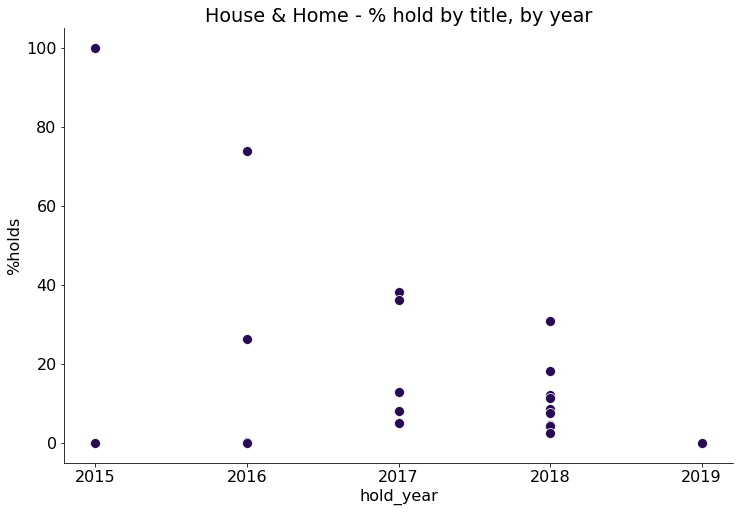

In [37]:
generate_scatter('House & Home')
plt.savefig('imgs/scatt_3.png', bbox_inches="tight")

In [38]:
def generate_scatter_bulk(ax, genre=sorted(genresT)):
    scat_dt = gen_titles[gen_titles.genre==genre].sort_values('%holds', ascending=False)
    
    #getting some subtitles off the titles to make them smaller
    scat_dt['title'] = scat_dt['title'].apply(lambda title: title.split(':')[0])
    
    #Creating a dict for the top annotations
    top_annots = defaultdict()
    yearS = gen_titles.hold_year.unique().tolist()
    
    for year in yearS:
        try:
            content = defaultdict()
            trans_dt = scat_dt[scat_dt.hold_year==year].iloc[:1,:]
            content['title'] = trans_dt['title'].values[0]
            content['%holds'] = trans_dt['%holds'].values[0]
            content['total_hold'] = trans_dt['total_hold'].values[0]
            content['year'] = trans_dt['hold_year'].values[0]
            top_annots[year] = content
        except IndexError:
            continue
    
    sns.set_palette('inferno')                                                        
    s1 = sns.scatterplot(x='hold_year', y='%holds', s=95, data=scat_dt, palette='purple', ax=ax)
    ax.set_title(genre,fontweight="bold", size=20)
    
    #making the annottions
    adt_vert_space = 0
    previous_holds = 0
    position = 'right'
    for key, value in top_annots.items():
        hold_diff = abs(value['%holds'] - previous_holds)
        #check if needs to change label position
        if hold_diff < 4 and previous_holds != 0:
            position = 'left'
        text = '{}, {}%'.format(value['title'], round(value['%holds'],0))
        s1.text(value['year']+0.1, value['%holds']+adt_vert_space, text, horizontalalignment=position, 
                                                    size='small', color='black', weight='semibold')
        adt_vert_space += 0.0
        previous_holds = value['%holds']
                                                               
    sns.despine()
    plt.xticks([2015, 2016, 2017, 2018, 2019])
    plt.title('{} - % hold by title, by year'.format(genre))
    return s1

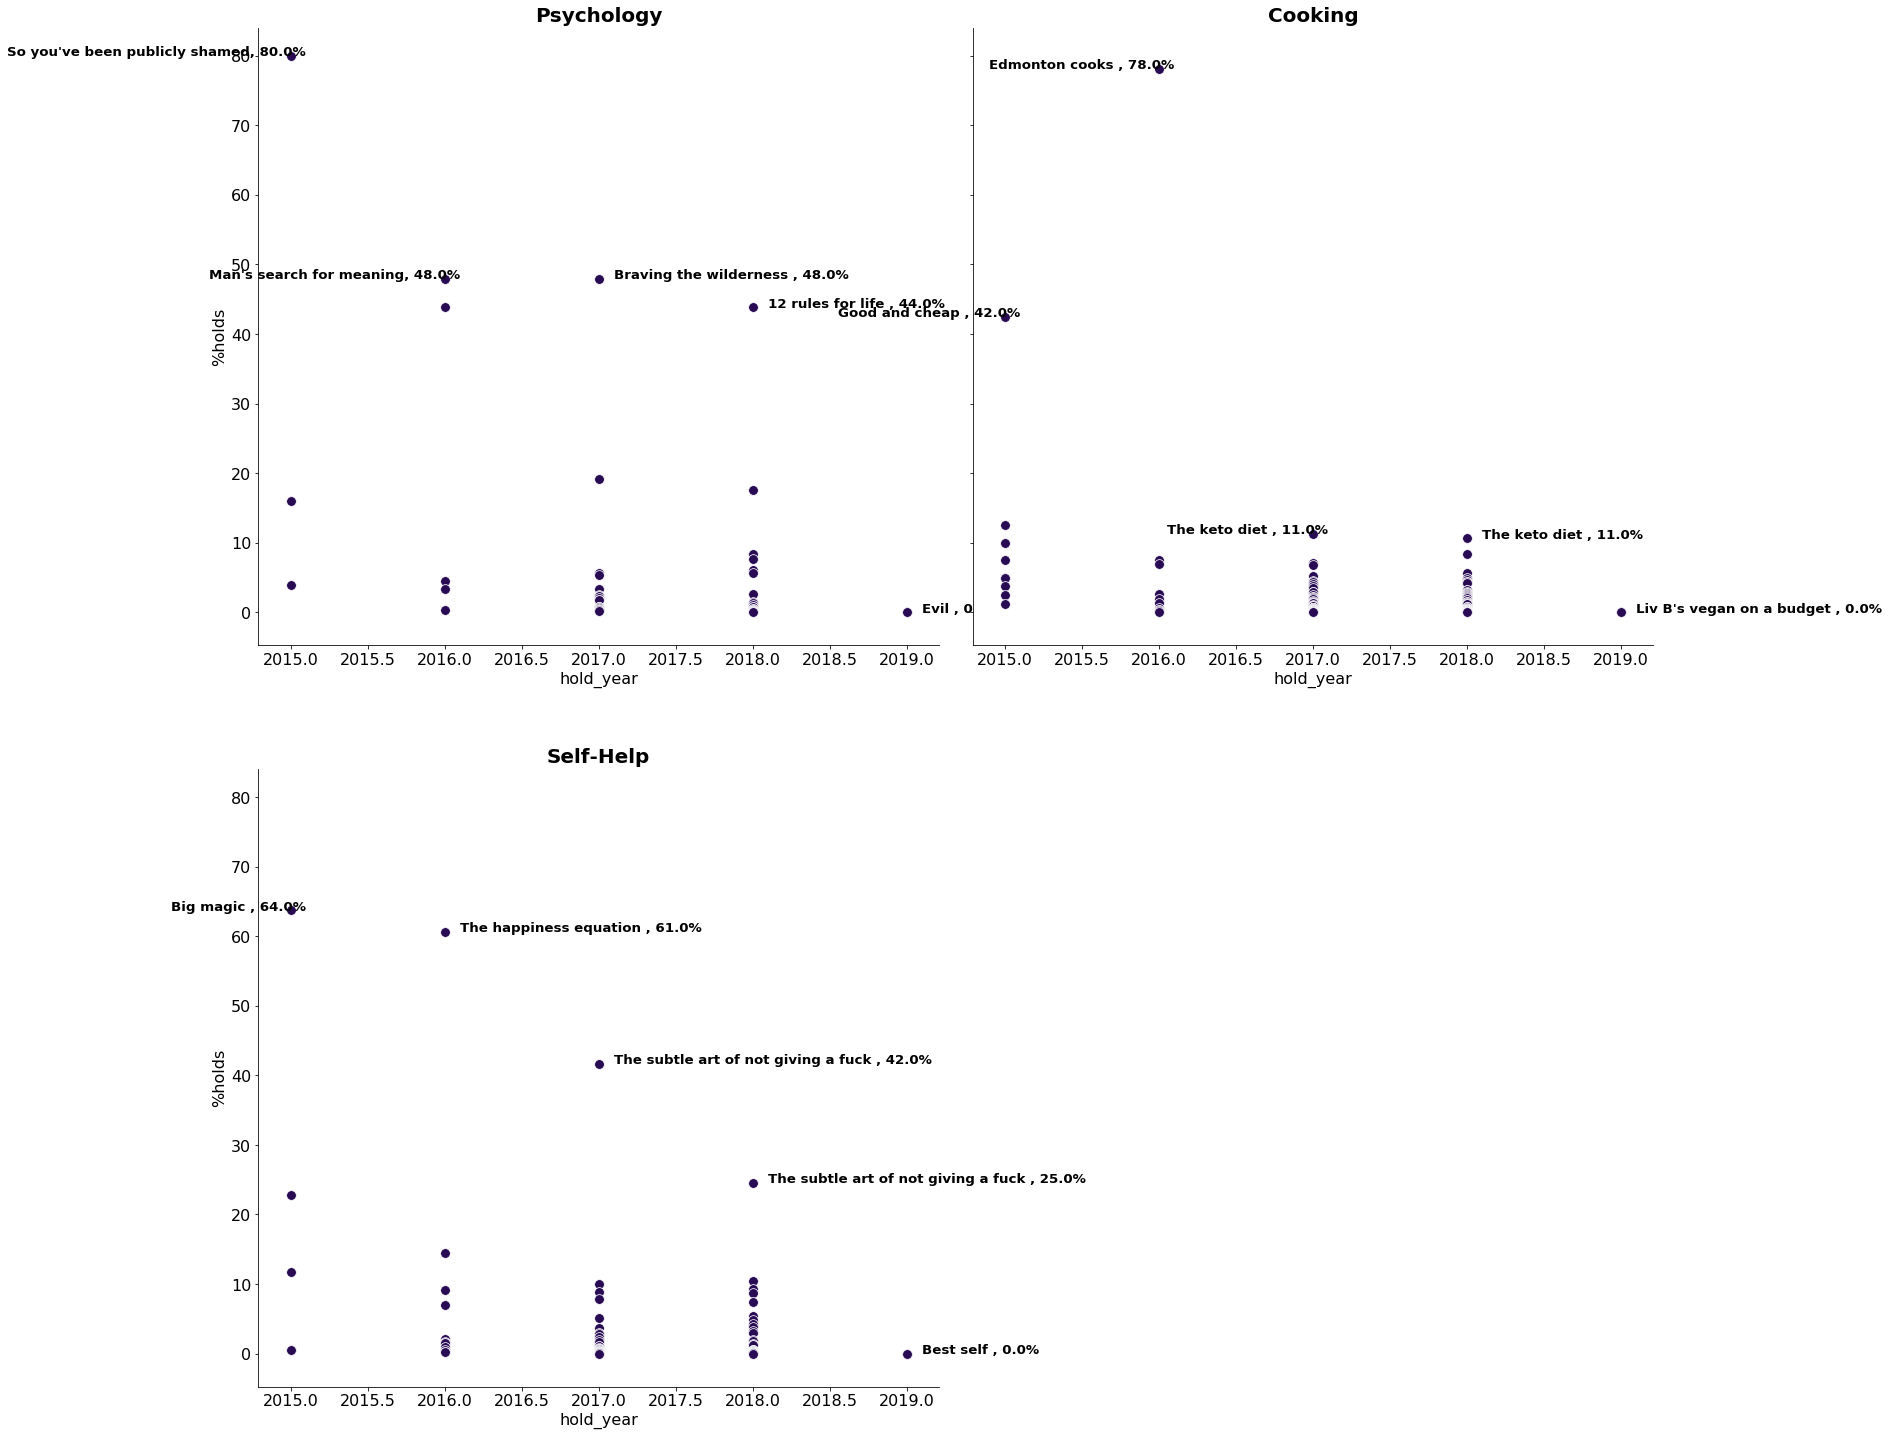

In [39]:
fig22, ax22 = plt.subplots(2,2, figsize=(25,25), sharey=True)

rowH = 0
colH = 0
for genre in high_growth1:
    if colH>1:
        colH = 0
        rowH += 1
    generate_scatter_bulk(ax22[rowH,colH], genre)
    colH += 1

plt.subplots_adjust(wspace=0.05)
ax22[-1, -1].set_visible(False)

plt.savefig('imgs/scatt_1.png', bbox_inches="tight")

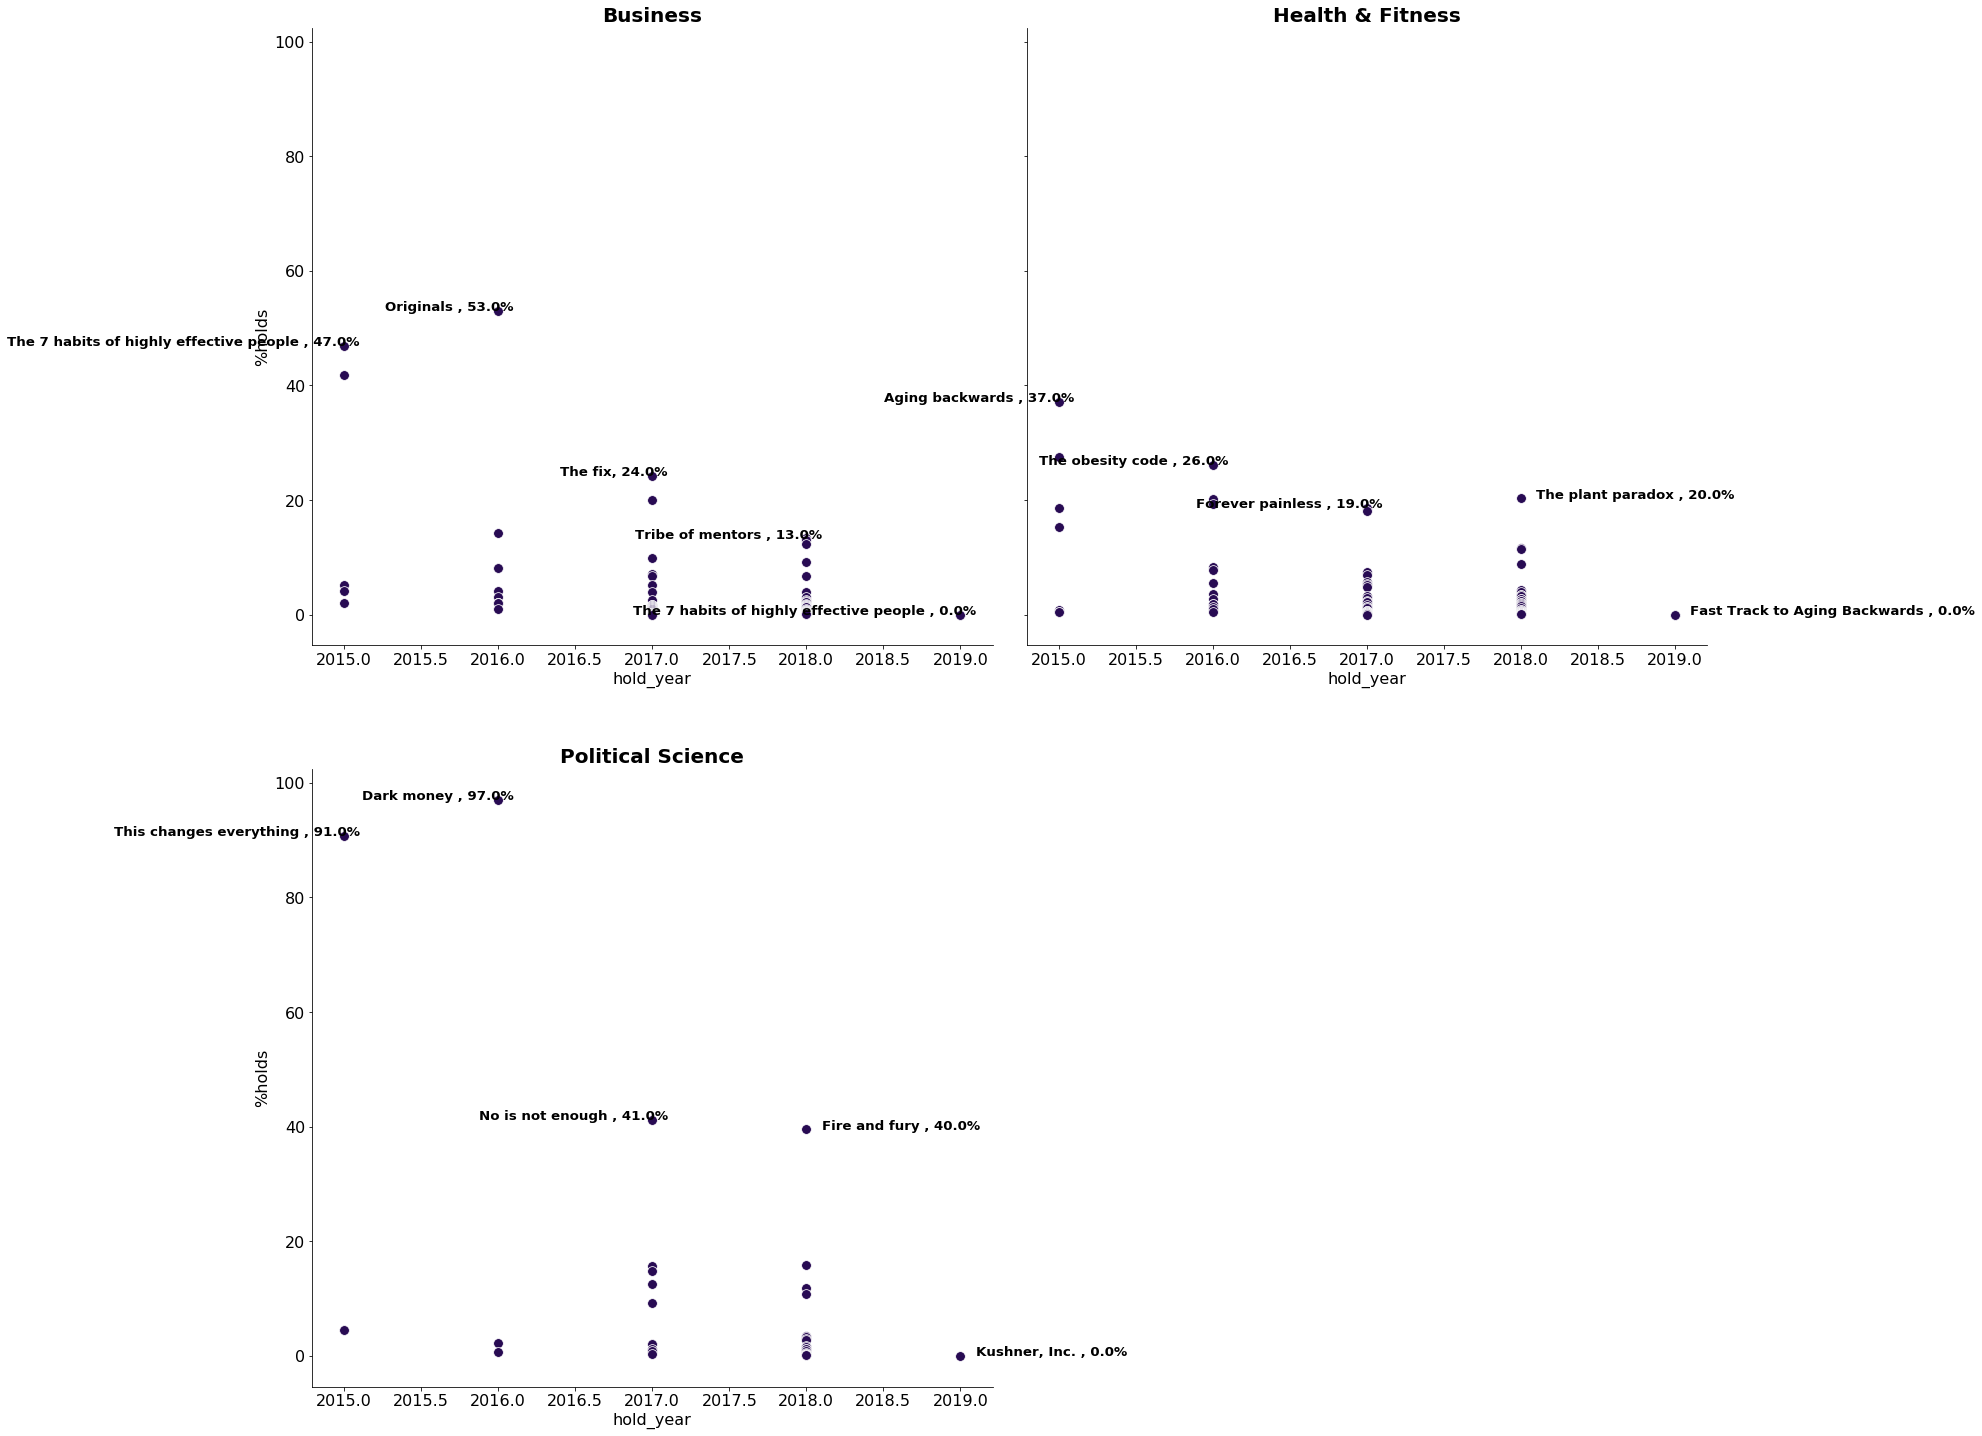

In [40]:
fig23, ax23 = plt.subplots(2,2, figsize=(25,25), sharey=True)

rowH = 0
colH = 0
for genre in high_growth2:
    if colH>1:
        colH = 0
        rowH += 1
    generate_scatter_bulk(ax23[rowH,colH], genre)
    colH += 1

plt.subplots_adjust(wspace=0.05)
ax23[-1, -1].set_visible(False)

plt.savefig('imgs/scatt_2.png', bbox_inches="tight")

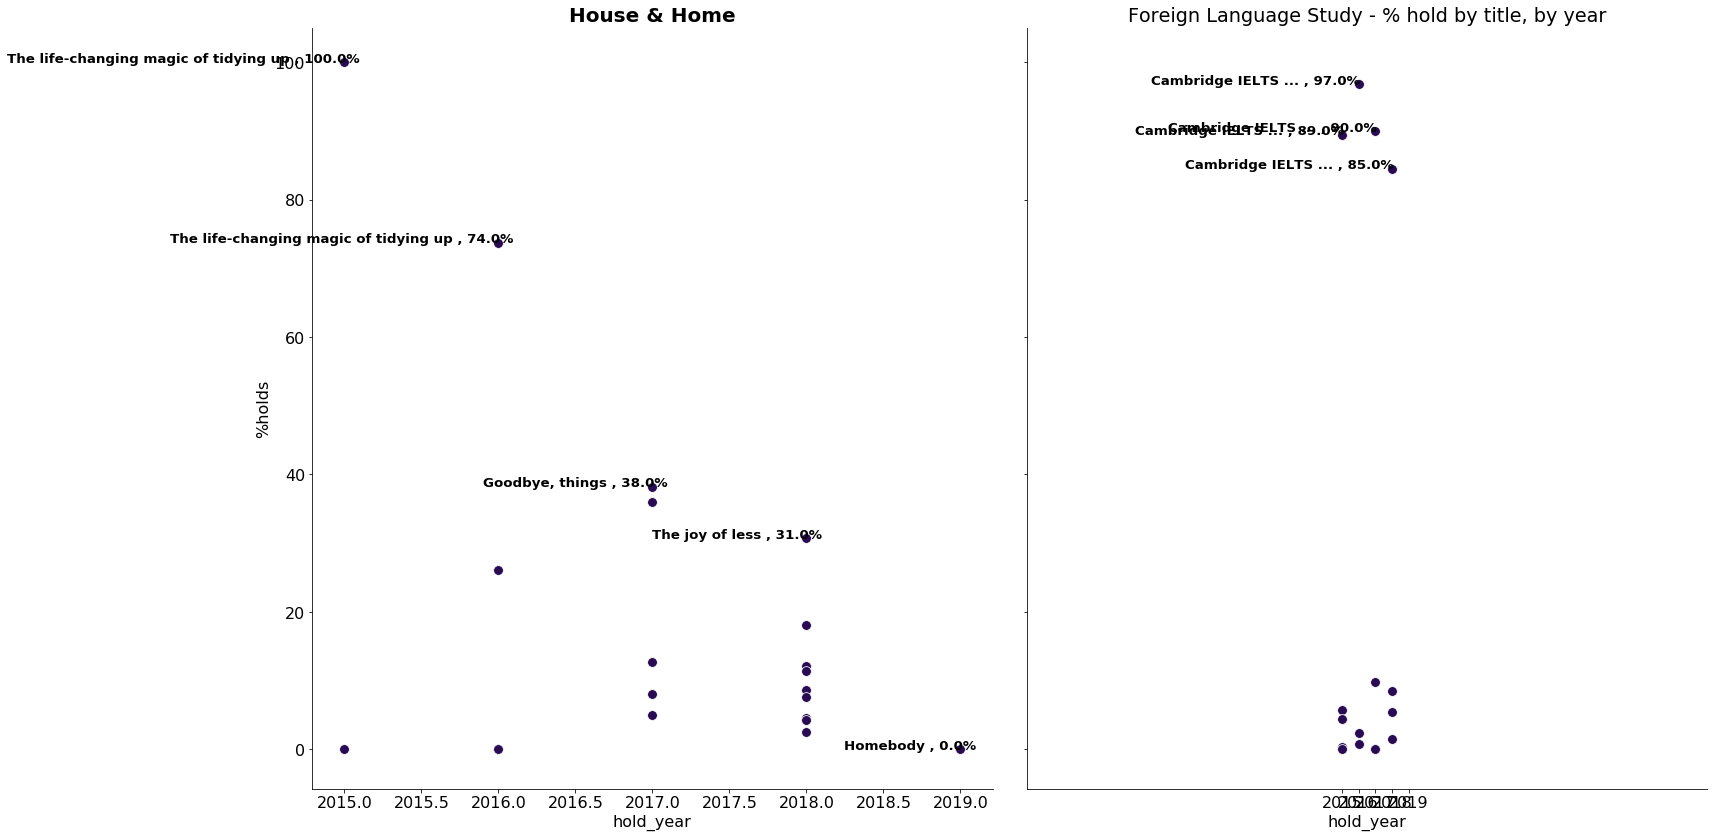

In [41]:
fig33, ax33 = plt.subplots(1,2, figsize=(25,14), sharey=True)

rowH = 0
colH = 0
for genre in decaying:
    generate_scatter_bulk(ax33[colH], genre)
    colH += 1

plt.subplots_adjust(wspace=0.05)
ax23[-1, -1].set_visible(False)

plt.savefig('imgs/scatt_3.png', bbox_inches="tight")

What happened to House & Home? 
R: Marie Kondo lost popularity

#### One last question: do big branches pushes for more genre variety or not?

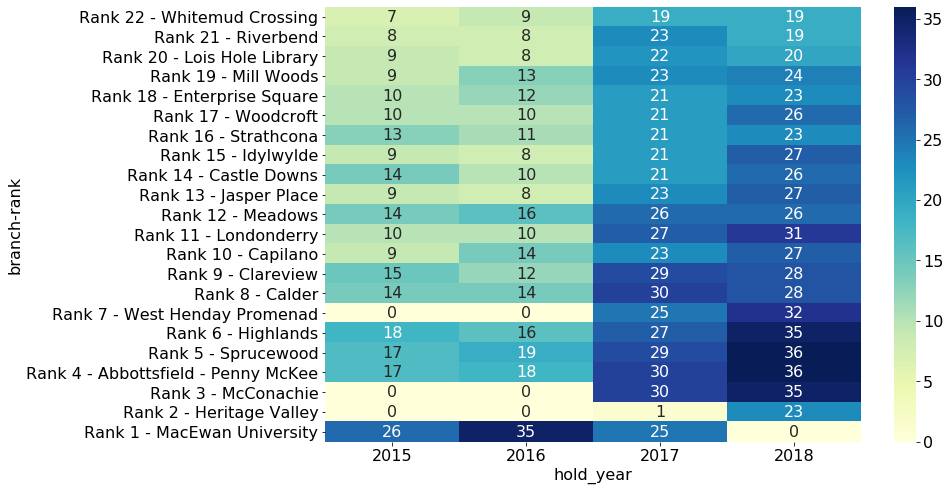

In [42]:
# transforming the data
gen_diver = gen_heat.groupby(['hold_year', 'branch_name', 'size_rank', 'branch-rank']).agg(
                                                                        count_genres=('genre', 'count'))

gen_diver = gen_diver.reset_index()


div_piv= gen_diver.pivot_table(index=['size_rank', 'branch-rank'], values='count_genres', columns='hold_year')
div_piv= div_piv.fillna(0).sort_values('size_rank', ascending=False)
div_piv = div_piv.reset_index('size_rank').drop('size_rank', axis=1)


sns.heatmap(div_piv, annot=True, cmap="YlGnBu")

plt.savefig('imgs/diver_heat.png', bbox_inches="tight")


##### Exploring genre patterns geographically

In [43]:
#getting the addresses of the branches 
brcInfo = pd.read_csv('Public_Libraries.csv')
keep_columns = ['Branch ID', 'Branch', 'Address', 'Latitude', 'Longitude']
brcInfo = brcInfo[keep_columns]

brcInfo.sort_values('Branch ID').head()

,Branch ID,Branch,Address,Latitude,Longitude
7,EPLABB,Abbottsfield - Penny McKee,3410 - 118 Avenue,53.570451,-113.391518
20,EPLCAL,Calder,12710 - 131 Avenue NW,53.590515,-113.542369
12,EPLCLV,Clareview,3808 - 139 Avenue,53.601302,-113.401769
14,EPLCPL,Capilano,9915 - 67 Street,53.537896,-113.419927
11,EPLCSD,Castle Downs,"106 Lakeside Landing, 15379 Castle Downs Rd",53.615736,-113.516633


In [44]:
#Creating the data frame by branch and genre to start exploring
g = data.loc[:,['branch_id', 'date', 'genre', 'holds']]
g.loc[:,'date'] = pd.to_datetime(g['date'])
g.loc[:,'hold_year'] = g.date.dt.year

# merging
g_group = g.groupby(['hold_year', 'branch_id', 'genre']).sum().sort_values(['hold_year', 'branch_id', 'holds'], ascending=False)
g_group = g_group.reset_index()
g_merged = g_group.merge(brcInfo, right_on='Branch ID', left_on='branch_id').set_index('hold_year')
g_merged.head()

,branch_id,genre,holds,Branch ID,Branch,Address,Latitude,Longitude
hold_year,,,,,,,,
2019,EPLWOO,Fiction,834,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2019,EPLWOO,Biography & Autobiography,294,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2019,EPLWOO,Cooking,77,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2018,EPLWOO,Fiction,22559,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2018,EPLWOO,Cooking,3617,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864


In [45]:
#geting the most popular genre per branch, per year considering number of holds

# building the dict for the job!
branch_ids = g_merged.branch_id.unique().tolist()
years = [2015, 2016, 2017, 2018]

master_dict = {}

for year in years:
    master_content = {}
    base = g_merged.loc[year, ['genre','holds', 'branch_id', 'Latitude', 'Longitude', 'Branch']]
    for branch in branch_ids:
        inside_content = {}
        try:
            inside_content['Branch'] = base[base.branch_id == branch].iloc[0,]['Branch']
            inside_content['genre'] = base[base.branch_id == branch].iloc[0,]['genre']
            inside_content['holds'] = base[base.branch_id == branch].iloc[0,]['holds']
            inside_content['Latitude'] = base[base.branch_id == branch].iloc[0,]['Latitude']
            inside_content['Longitude'] = base[base.branch_id == branch].iloc[0,]['Longitude']
            master_content[branch] = inside_content
        except:
            continue
        
    master_dict[year] = master_content

In [46]:
# normalization function - for the marker size 

def normalize(number, upper=20, lower=1):
    normalized = ((number -lower)/(upper - lower)) * 10 
    return int(normalized+9) # +6 to make small numbers more visible in the map

# colors for markers
marker_c = ['red', 'blue', 'green', 'purple', 'orange', 'darkred',
            'lightred', 'beige', 'darkblue', 'darkgreen', 'cadetblue', 
            'darkpurple', 'pink', 'lightblue', 'lightgreen', 
            'gray', 'black', 'lightgray']


In [47]:
#base map
m = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)

#Generating the color of the markers
np.random.seed(5)
top_genre = set()
for key, value in master_dict.items():
    for key2, value2 in value.items():
        top_genre.add(value2['genre'])
    
genre_color = {genre:marker_c[np.random.randint(0,len(marker_c)-1)] for genre in top_genre}

@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def generate_geo_genre(year=[2015, 2016, 2017, 2018]):
    '''Generate Geo Map with round markers with the size of number of holds per genre in each branch
       Represents all time sucesses in number of holds
       
       year = integer, year you would like to analyze
        '''
    
    m = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)
    
    #Generating the color of the markers
    np.random.seed(1)
    top_genres = {values['genre'] for key,values in master_dict[year].items()}
    genre_color_checking = {genre:genre_color[genre] for genre in top_genres}
    
    #seting up parameters for the marker size
    hold_list = [value['holds'] for key,value in master_dict[year].items() ]
    maxH, minH = max(hold_list), min(hold_list)

    for branch, values in master_dict[year].items():
        folium.CircleMarker([values['Latitude'], values['Longitude']],
                                radius = normalize(values['holds'], maxH, minH),
                                popup = [values['genre']],
                                color = 'gray',
                                fill=True,
                                fill_opacity=0.9,
                                fill_color=genre_color[values['genre']],
                                tooltip= values['Branch'],
                               ).add_to(m)
        
    #generate legends snipets
    snipets = []
    for key, value in genre_color_checking.items():
        snipets.append(
            '&nbsp; {} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{}"></i>'.format(
                                                                                        key, value)
        )
    legend_entries = '<br>'.join(snipets)
        
        
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b> Map Legend  </b> <br>
                            {}
                              </i>
                </div>
                '''.format(legend_entries) 

    m.get_root().html.add_child(folium.Element(legend_html))
    m.get_root().html.add_child(folium.Element(year_html))
    print('Predominant Genre in number of all time holdings by branch')
    
    return m

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

> Millwoods resisted the Fiction domination, but it was just a matter of time.. 

Lets try **taking off Fiction** to see other predominant Genres 

In [48]:
#geting the most popular genre per branch, per year considering number of holds

# building the dict for the job!
branch_ids = g_merged.branch_id.unique().tolist()
years = [2015, 2016, 2017, 2018]

g_merged_wf = g_merged[g_merged.genre != 'Fiction'] # Taking off Fiction

master_dict2 = {}

for year in years:
    master_content = {}
    base = g_merged_wf.loc[year, ['genre','holds', 'branch_id', 'Latitude', 'Longitude', 'Branch']]
    for branch in branch_ids:
        inside_content = {}
        try:
            inside_content['Branch'] = base[base.branch_id == branch].iloc[0,]['Branch']
            inside_content['genre'] = base[base.branch_id == branch].iloc[0,]['genre']
            inside_content['holds'] = base[base.branch_id == branch].iloc[0,]['holds']
            inside_content['Latitude'] = base[base.branch_id == branch].iloc[0,]['Latitude']
            inside_content['Longitude'] = base[base.branch_id == branch].iloc[0,]['Longitude']
            master_content[branch] = inside_content
        except:
            continue
        
    master_dict2[year] = master_content

In [49]:
#base map
m2 = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)

#Generating the color of the markers
np.random.seed(15)
top_genre2 = set()
for key, value in master_dict2.items():
    for key2, value2 in value.items():
        top_genre2.add(value2['genre'])
    
genre_color2 = {genre:marker_c[np.random.randint(0,len(marker_c)-1)] for genre in top_genre2}

# Running it without fiction
@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def generate_geo_genre(year=[2015, 2016, 2017, 2018]):
    '''Generate Geo Map with round markers with the size of number of holds per genre in each branch
       Represents all time sucesses in number of holds
       
       year = integer, year you would like to analyze
        '''
    
    m2 = folium.Map(location=[53.531611, -113.513975], zoom_start=11.4)
    
    #checking which markers should appear
    top_genres = {values['genre'] for key,values in master_dict2[year].items()}
    genre_color_check = {genre:genre_color2[genre] for genre in top_genres}
    
    
    #seting up parameters for the marker size
    hold_list = [value['holds'] for key,value in master_dict[year].items() ]
    maxH, minH = max(hold_list), min(hold_list)

    for branch, values in master_dict2[year].items():
        folium.CircleMarker([values['Latitude'], values['Longitude']],
                                radius = normalize(values['holds'], maxH, minH),
                                popup = [values['genre']],
                                color = 'grey',
                                fill=True,
                                fill_opacity=0.9,
                                fill_color=genre_color2[values['genre']],
                                tooltip= values['Branch'],
                               ).add_to(m2)
        
    #generate legends snipets
    snipets = []
    for key, value in genre_color_check.items():
        snipets.append(
            '&nbsp; {} &nbsp; <i class="fa fa-map-marker fa-2x" style="color:{}"></i>'.format(
                                                                                        key, value)
        )
    legend_entries = '<br>'.join(snipets)
        
        
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: auto; height: auto; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color:white; border-radius:10px; padding: 7px 9px 7px;
                            ">&nbsp; <b>Map Legend</b> <br>
                            {}
                              </i>
                </div>
                '''.format(legend_entries) 

    m2.get_root().html.add_child(folium.Element(legend_html))
    m2.get_root().html.add_child(folium.Element(year_html))
    print('Predominant Genre in number of all time holdings by branch - WITHOUT FICTION')
    
    return m2

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

### Exploring HeatMaps

##### Variety HeatMap - Areas with more diversity of genres in the top 10s

In [50]:
#Creating the data frame by branch and genre to start exploring
h = data.loc[:,['branch_id', 'date', 'genre']]
h.loc[:,'date'] = pd.to_datetime(h['date'])
h.loc[:,'hold_year'] = h.date.dt.year

h_group = h.groupby(['hold_year', 'branch_id', 'genre']).agg(genre_count=('genre', 'size'))
h_group = h_group.sort_values(['hold_year', 'branch_id', 'genre_count'], ascending=False).reset_index()

#merging to get coordinates
h_merged = h_group.merge(brcInfo, right_on='Branch ID', left_on='branch_id')#.set_index('hold_year')
h_merged.head()

,hold_year,branch_id,genre,genre_count,Branch ID,Branch,Address,Latitude,Longitude
0,2019,EPLWOO,Fiction,7,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
1,2019,EPLWOO,Biography & Autobiography,2,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
2,2019,EPLWOO,Cooking,1,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
3,2018,EPLWOO,Fiction,235,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864
4,2018,EPLWOO,Cooking,38,EPLWOO,Woodcroft (Westmount),13420 - 114 Avenue,53.563756,-113.553864


In [51]:
# Variety of rankings heatmap

# building the dataframe
i = h_merged
i_group = i.groupby(['hold_year', 'branch_id', 'Latitude', 'Longitude']).agg(number_of_genres=('genre','size'))
i_group = i_group.reset_index()

@interact(year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def diversity_heatmap(year=[2015, 2016, 2017, 2018]):

    m3 = folium.Map(location=[53.531611, -113.513975], zoom_start=9.4)
    
    heat_dt = i_group[i_group.hold_year == year]
    heat_dt['weight'] = heat_dt.loc[:,'number_of_genres'] / heat_dt.loc[:,'number_of_genres'].sum()
    
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    params = heat_dt.loc[:,['Latitude', 'Longitude', 'weight']].values
    m3.get_root().html.add_child(folium.Element(year_html))
    m3.add_child(plugins.HeatMap(params, radius=15))
    
    print( 'Regions with more variety of genres in the top 10s')
    return m3

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Output()), _dom_classes=(…

##### Genre Intensity by area during years - number of apperances in the top 10

In [52]:
# Variety of rankings heatmap

# building the dataframe
heat_gen = h_merged.groupby(['hold_year','branch_id', 'Latitude', 'Longitude', 'genre']).agg(
                                                                            genre_count=('genre_count', 'sum'))

hbranchs = list(h_merged.branch_id.unique())
hyears = [2015, 2016, 2017, 2018]

heat_gen = heat_gen.reset_index(['Latitude', 'Longitude', 'genre'])
heat_gen['%genre'] = 0

for year in hyears:
    for branch in hbranchs:
        try:
            total = heat_gen.loc[(year,branch), 'genre_count'].sum() 
            heat_gen.loc[(year,branch), '%genre'] = heat_gen.loc[(year,branch), 'genre_count'] / total
        except KeyError:
            continue

heat_gen = heat_gen.reset_index()

u_genres = heat_gen.genre.sort_values().unique().tolist() #exclude irrelevant

@interact(genre = u_genres, year = widgets.IntSlider(min=2015, max=2018, step=1, value=2015))
def genre_heatmap(year, genre):

    m4 = folium.Map(location=[53.531611, -113.513975], zoom_start=9.4)
    
    heat_dt = heat_gen[heat_gen.hold_year == year]
    heat_dt = heat_dt[heat_dt.genre == genre]
    
    year_html = '''
        <div style="position: fixed; 
                            top: 10px; right: 10px; width: auto; height: auto; 
                            z-index:9999; font-size:14px;
                            color: black; font-size: 45px;
                            ">&nbsp; <b> {}  </b> <br>
                              </i>
                </div>'''.format(year) 
    
    m4.get_root().html.add_child(folium.Element(year_html))
    
    params = heat_dt[['Latitude', 'Longitude', '%genre']].values
    m4.add_child(plugins.HeatMap(params, radius=15))
    
    return m4

interactive(children=(IntSlider(value=2015, description='year', max=2018, min=2015), Dropdown(description='gen…

### - 'What are the most popular books?' 

In [59]:
pop = data.loc[:, ['hold_year', 'branch_id', 'branch_name', 'title', 'genre', 'holds', 'google_rating']]
pop['google_rating'] = pop['google_rating'].fillna(0)

popest = pop.groupby(['title', 'genre', 'google_rating']).agg(total_holds=('holds', 'sum')).sort_values('total_holds', ascending=False)
pop_htotal = popest.total_holds.sum()
popest['%holds'] = (popest['total_holds'] / pop_htotal) * 100
popest = popest.reset_index(['genre', 'google_rating'])
popest['google_rating'] = popest['google_rating'].fillna('NA') 

# def print_tops(top_number=10):
#     print('Top {} off all time has {}% of the total holdings.'.format(top_number,
#                                                                       round(popest.iloc[:top_number,3].sum(),1)))

# tops = [10, 15, 30, 50, 100]    
# for top in tops:
#     print_tops(top)

popest.head(10)#.to_excel('toptitlesalltime.xlsx')

,genre,google_rating,total_holds,%holds
title,,,,
The girl on the train,Fiction,3.5,39505,2.699884
The life-changing magic of tidying up : the Japanese art of decluttering and organizing,House & Home,3.5,22365,1.528488
Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate,Foreign Language Study,0.0,21708,1.483586
The subtle art of not giving a fuck : a counterintuitive approach to living a good life,Self-Help,0.0,15583,1.064987
Into the water,Fiction,3.0,14219,0.971767
12 rules for life : an antidote to chaos,Psychology,4.0,12480,0.852919
All the light we cannot see : a novel,Fiction,4.0,11615,0.793802
The Alice network,Fiction,4.0,11399,0.779040
The hate u give,Fiction,0.0,10927,0.746782


Interesting: it seems that the logic for higher ratings going towards greater holdings numbers stands until rating 4.0 (if we ignore the outliers), an after that it decays which logically we would not expect.

Why? There should be another variable pushing this trend more than the rating. Les try genre

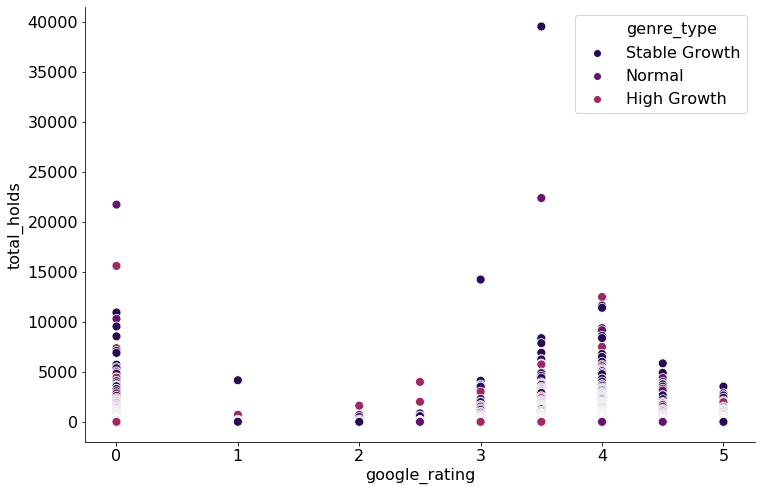

In [60]:
# bringing the genre analysis do the scatter
popest['genre_type'] = ''
# lets use the high and stable lists for genre to classify it
high_growth_genres= high_growth
stable_growth_genres = stable_growth

def classify_genre(genre):
    if genre in high_growth_genres:
        return 'High Growth'
    elif genre in stable_growth_genres:
        return 'Stable Growth'
    else:
        return 'Normal'

popest['genre_type'] = popest.genre.apply(classify_genre)

sns.scatterplot(x='google_rating', y='total_holds', hue='genre_type', data=popest, s=80)
sns.despine()

plt.savefig('imgs/google.png', bbox_inches="tight")

It is still mixed and doesnt show any relation, it seems that whoever has the most number of stable genres in it would win. So let's ignore the google rating factor.

Lets explore more the top 10 and try to see any patterns here:

#### Big branch factor: do the success of this books has some relation to being featured in bigger branches?

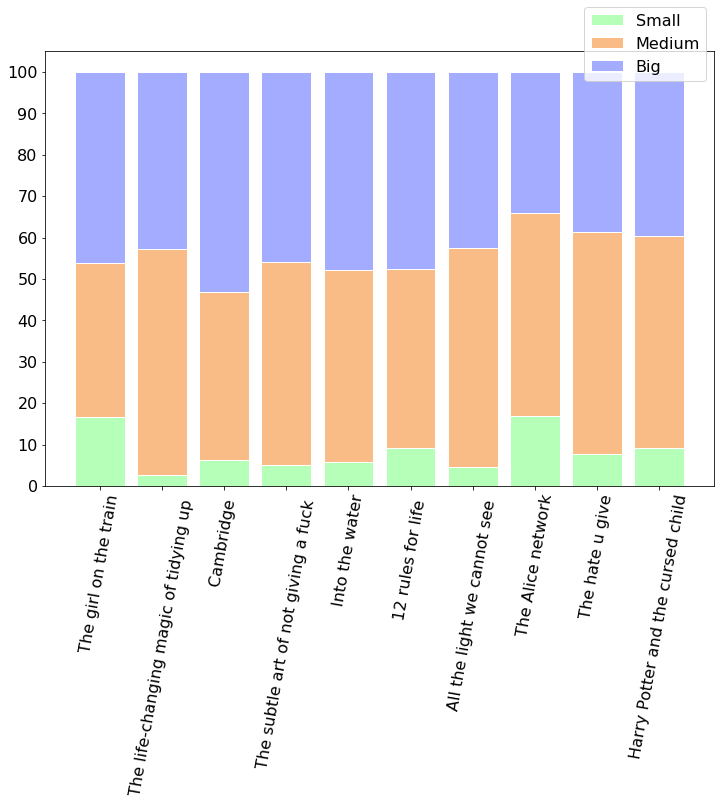

In [61]:
#create graph to see proportion by each branch size in total holdings
pop_brand = pop.groupby([ 'branch_name', 'title']).agg(total_holds=('holds', 'sum'))
pop_brand = pop_brand.reset_index()

#Cleaning branch names to make them smaller
pop_brand['branch_name'] = pop_brand['branch_name'].apply(lambda name: name.replace(' Branch', ''))
pop_brand['branch_name'] = pop_brand['branch_name'].apply(lambda name: name.split(' (')[0])

#lets use rank_dict built for the genre analysis
pop_brand['branch_size_rank'] = pop_brand.branch_name.apply(lambda b: rank_dict[b] )

#let's create levels for the size_rank
# >100k , Big - 50<x<100 - Medium, 50<x Small
def size_type(rank):
    if rank >= 19:
        return 'Big'
    elif rank <= 8:
        return 'Small'
    else:
        return 'Medium'

pop_brand['size_type'] = pop_brand.branch_size_rank.apply(size_type)

#grouping for the graph
pop_brand_g = pop_brand.groupby(['title', 'size_type']).agg(tholds=('total_holds', 'sum'))

#getting the top10list
top10pop = popest.reset_index().loc[:9,'title'].tolist()
toptitles = popest.reset_index().title.unique().tolist()
types = ['Big', 'Small', 'Medium']

#creating the % columns
pop_brand_g['%holds'] = 0
pop_brand_g = pop_brand_g.reset_index('size_type')

for title in toptitles:
    try:
        total = pop_brand_g.loc[title,'tholds'].sum()
        pop_brand_g.loc[title, '%holds'] = (pop_brand_g.loc[title, 'tholds'] / total) * 100
    except IndexError:
        pop_brand_g.loc[title, 'tholds'] = 0 
        pop_brand_g.loc[title, '%holds'] = 0

pop_brand_g = pop_brand_g.reset_index()
pop_graph = pop_brand_g[pop_brand_g.title.isin(top10pop)]
r = list(range(10))

#fixing title names
top10books = [tit.split(':')[0] for tit in top10pop]
top10books = [tit.split('IELTS')[0] for tit in top10books]
top10books = [tit.split('.')[0] for tit in top10books]

#ploting the stacked bar graph
bar_colors = ['#b5ffb9', '#f9bc86', '#a3acff']
graphS = pop_graph[pop_graph.size_type=='Small']
graphM = pop_graph[pop_graph.size_type=='Medium']
graphB = pop_graph[pop_graph.size_type=='Big']


Sbottom = list(graphS['%holds'].values)
Mbottom = list(graphM['%holds'].values)
Bbottom = list(graphB['%holds'].values)
final_bottom = [s+m for s,m in zip(Sbottom,Mbottom)]

plt.bar(r,list(graphS['%holds'].values), color='#b5ffb9', edgecolor='white', label='Small')
plt.bar(r,list(graphM['%holds'].values), bottom=Sbottom, color='#f9bc86', edgecolor='white', label='Medium')
plt.bar(r,list(graphB['%holds'].values), bottom=final_bottom, color='#a3acff', edgecolor='white', label='Big')

plt.xticks(r,tuple(top10books), rotation=80)
plt.yticks(list(range(101))[::10])
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.12))

In [62]:
#create dataframe for heatmap with book rank in the branch by year
pop_rank = pop.groupby(['hold_year', 'branch_name', 'title']).agg(total_holds=('holds', 'sum'))
pop_rank = pop_rank.reset_index('title').sort_values(['hold_year','branch_name', 'total_holds'] ,ascending=False)

rank_branches = pop_rank.reset_index().branch_name.unique().tolist()
rank_years = [2015, 2016, 2017, 2018, 2019]

#adding ranking columns
pop_rank['%holds'] = 0
#pop_rank.loc[(2019, 'Woodcroft Branch'),'total_holds']
for year in rank_years:
    for branch in rank_branches:
        try:
            total = pop_rank.loc[(year,branch),'total_holds'].sum()
            pop_rank.loc[(year,branch), '%holds'] = (pop_rank.loc[(year,branch), 'total_holds'] / total) * 100
        except KeyError:
            continue

pop_rank = pop_rank.reset_index()

# Simplifying branch names
pop_rank['branch_name'] = pop_rank['branch_name'].apply(lambda name: name.replace(' Branch', ''))
pop_rank['branch_name'] = pop_rank['branch_name'].apply(lambda name: name.split(' (')[0])

#Lets bring size rank to build the further heatmaps using rank_dict as above
pop_rank['branch_size_rank'] = pop_rank.branch_name.apply(lambda b: rank_dict[b])

#Creating heamap branch labels
pop_rank['branch_labels'] = pop_rank.branch_name.apply(lambda b: 'Rank:{} - {}'.format(rank_dict[b], b))
            
pop_rank.head() #just testing

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/pandas/core/indexing.py:1761: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2857: PerformanceWarning:

indexing past lexsort depth may impact performance.

/Users/fernandomeira/.local/share/virtualenvs/EdmontonLibraryEDA-hCCnIGB0/lib/python3.8/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning:

indexing past lexsort depth may impact performance.



,hold_year,branch_name,title,total_holds,%holds,branch_size_rank,branch_labels
0,2019,Woodcroft,The huntress : a novel,199,16.514523,17,Rank:17 - Woodcroft
1,2019,Woodcroft,"The woo woo : how I survived ice hockey, drug ...",172,14.273859,17,Rank:17 - Woodcroft
2,2019,Woodcroft,The hate u give,136,11.286307,17,Rank:17 - Woodcroft
3,2019,Woodcroft,A good wife : escaping the life I never chose,122,10.124481,17,Rank:17 - Woodcroft
4,2019,Woodcroft,Brother,110,9.128631,17,Rank:17 - Woodcroft


In [63]:
#create heatmap with book rank for the top 10 all time in the branch by year

@interact
def generate_heatsns(title = top10pop):

    heater = pop_rank[pop_rank.title==title]
    heater_piv= heater.pivot_table(index=['branch_size_rank', 'branch_labels'], 
                                   values='%holds', columns='hold_year')
    heater_piv= heater_piv.fillna(0).sort_values('branch_size_rank', ascending=False)
    heater_piv = heater_piv.reset_index('branch_size_rank').drop('branch_size_rank', axis=1)

    plt.title('Book Holding Ranking by Branch by Year')
    
    return sns.heatmap(heater_piv,cmap="YlGnBu", annot=True)

interactive(children=(Dropdown(description='title', options=('The girl on the train', 'The life-changing magic…

In [64]:
#Building dataset for the lineplots

#getting release years
rleaseDt = data.loc[:,['title', 'publishing_Date']].drop_duplicates('title')

#merging with last dt 
pop_rel = pop_rank.merge(rleaseDt, how='left', on='title')

pop_rel.head()

,hold_year,branch_name,title,total_holds,%holds,branch_size_rank,branch_labels,publishing_Date
0,2019,Woodcroft,The huntress : a novel,199,16.514523,17,Rank:17 - Woodcroft,2019.0
1,2019,Woodcroft,"The woo woo : how I survived ice hockey, drug ...",172,14.273859,17,Rank:17 - Woodcroft,2018.0
2,2019,Woodcroft,The hate u give,136,11.286307,17,Rank:17 - Woodcroft,2017.0
3,2019,Woodcroft,A good wife : escaping the life I never chose,122,10.124481,17,Rank:17 - Woodcroft,2019.0
4,2019,Woodcroft,Brother,110,9.128631,17,Rank:17 - Woodcroft,2018.0


In [65]:
#fixing mannually to wrong publishing years
pop_rel = pop_rel.set_index('title')
pop_rel.loc['Into the water', 'publishing_Date'] = 2017.0
pop_rel.loc['The Alice network', 'publishing_Date'] = 2017.0
pop_rel = pop_rel.reset_index()

@interact
def generate_stripp_pyear(title=top10pop):
    rel_plotDt = pop_rel[pop_rel.title == title ]

    splot = sns.stripplot(x='hold_year', y='%holds', hue='branch_size_rank',palette='Blues', 
                          data=rel_plotDt, size=12)

    #annotation for publishing year
    publish_year = int(rel_plotDt.iloc[1,7])
    print(rel_plotDt.iloc[1,7])
    ymin, ymax = splot.get_ylim()
    xmin, xmax = splot.get_xlim()
    xcoords, xtexts = plt.xticks()[0], plt.xticks()[1]
    xaxis_dict= {year.get_text():coord for year,coord in zip(xtexts,xcoords)}

    print(publish_year)
    if publish_year >= 2015:
        splot.text(xaxis_dict[str(publish_year)], ymax, "Publishing Year", horizontalalignment='center', 
                size=12, color='red', weight='semibold')
    else:
        splot.text(xmax, ymax, "Published in {}".format(publish_year), 
                   horizontalalignment='center', size=12, color='blue', weight='semibold')
        


    sns.despine()
    plt.legend(bbox_to_anchor=(1.13, 1), title='Branch Size Index')
    
    return splot

interactive(children=(Dropdown(description='title', options=('The girl on the train', 'The life-changing magic…

#### Understanding top 10 titles evolution

Seeings years separately

In [66]:
pop = data.loc[:, ['hold_year', 'branch_id', 'branch_name', 'title', 'genre', 'holds', 'publishing_Date']]

pop10 = pop.groupby(['hold_year', 'title', 'genre', 'publishing_Date']).agg(total_holds=('holds', 'sum'))
pop10 = pop10.reset_index(['title', 'genre', 'publishing_Date'])

years10 = sorted(pop.hold_year.unique().tolist())

correct_pop = {
    'The Martian : a novel' : 2011,
    'Into the water': 2017,
    "The handmaid's tale": 1985,
    'The Alice network': 2017,
    'Camino Island': 2017,
    'Little fires everywhere': 2017,
    'By chance alone : a remarkable true story of courage and survival at Auschwitz': 2016,
    "The girl in the spider's web": 2015,
}

import pdb

pop10 = pop10.reset_index().set_index('title')
for k in correct_pop.keys():
    #pdb.set_trace()
    pop10.loc[k,'publishing_Date'] = correct_pop[k]
pop10 = pop10.reset_index().set_index('hold_year')

@interact
def evol_totp10(year=years10):
    df = pop10.loc[year, :].sort_values('total_holds', ascending=False).iloc[:10,:].reset_index()
    return df

interactive(children=(Dropdown(description='year', options=(2015, 2016, 2017, 2018, 2019), value=2015), Output…

In [67]:
# trying to see the influence visual productions in book holdings

#creating the dict to check
visual_check = {
    2015 : {
        'The girl on the train' : False ,
        'The life-changing magic of tidying up : the Japanese art of decluttering and organizing': False ,
        'All the light we cannot see : a novel': False,
        'Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate': False,
        'Go set a watchman': False,
        "The girl in the spider's web": False,
        'In the unlikely event': False,
        'Why not me?': False,
        'The nightingale': False,
        'The Martian : a novel': True
    } ,
    2016: {
        'Harry Potter and the cursed child. Parts one and two': False,
        'The girl on the train' : True,
        'Me before you': True,
        'The life-changing magic of tidying up : the Japanese art of decluttering and organizing': False,
        'The nest': False,
        'Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate':False,
        'The illegal : a novel': False,
        'The widow': False,
        'When breath becomes air': False,
        'A great reckoning': False,
    } ,
    2017: {
        'Into the water': False,
        "The handmaid's tale": True,
        'Camino Island': False,
        'The woman in cabin 10': False,
        'The subtle art of not giving a fuck : a counterintuitive approach to living a good life': False,
        'Glass houses': False,
        'The Alice network': False,
        'Origin : a novel': False,
        'Cambridge IELTS ... : examination papers from the University of Cambridge Local Examinations Syndicate': False,
        'The late show': False,  
    } ,
    2018: {
        '12 rules for life : an antidote to chaos': False,
        'The subtle art of not giving a fuck : a counterintuitive approach to living a good life': False,
        'Educated : a memoir': False,
        'The hate u give': True,
        'A wrinkle in time': True,
        'The woman in the window': False,
        'Little fires everywhere': False,
        'The Alice network': False,
        'An American marriage : a novel': False,
        'Crazy rich Asians': True,
    } ,
    2019: {
        'Becoming': False,
        'Educated : a memoir': False,
        'Dog Man. Brawl of the wild': True,
        'Where the crawdads sing': False,
        'The tattooist of Auschwitz : a novel': False,
        'Homes : a refugee story': False,
        'The lost girls of Paris': False,
        'The silent patient': False,
        'By chance alone : a remarkable true story of courage and survival at Auschwitz': False,
        'Girl, wash your face : stop believing the lies about who you are so you can become who you were meant to be': False,     
    }
}

In [68]:
def create_alltop10s(years, func):
    all_dfs = []
    for year in years:
        df = func(year)
        df['Movie/Series'] = df['title'].apply(lambda t: visual_check[year][t])
        df['Hold on publishing year'] = df['publishing_Date'] == df['hold_year']
        all_dfs.append(df)
    
    consolidated_dataset = pd.concat(all_dfs)
    return consolidated_dataset

pop10f = create_alltop10s(years10,evol_totp10)

#creating some styling functions to make visualization easier
def color_bool(s):
    col = s == True
    return ['background-color: blue' if v else '' for v in col ]

@interact
def show_topstyle(year=years10):
    format_df = pop10f[pop10f.hold_year==year]
    return format_df#.style.apply(color_bool, axis=0, 
                                  #subset=pd.IndexSlice[:, ['Movie/Series', 'Hold on publishing year']])


interactive(children=(Dropdown(description='year', options=(2015, 2016, 2017, 2018, 2019), value=2015), Output…

In [69]:
for year in years10:
    d = show_topstyle(year)
    d.to_excel('df_{}.xlsx'.format(year), index=False)

It seems that in all the years, the most of the top ten is influenced by new books or by externl effects like Films or TV Series.

Seeing years accumulating

In [70]:
#creating dict to filter
yfilter = defaultdict()

for year in years10:
    year_crement = (year - 2015)+1
    yfilter[year] = list(range(2015,2015+year_crement))
    

# filtering and showing the top ten
@interact
def evol_top10acum(year=years10):
    pop10acum = pop10.reset_index()
    pop10acum = pop10acum[pop10acum.hold_year.isin(yfilter[year])]
    pop10acum = pop10acum.groupby(['title', 'genre' , 'publishing_Date']).agg(
                                                            total_holds=('total_holds', 'sum')).reset_index()
    pop10acum = pop10acum.sort_values('total_holds', ascending=False)
    
    return pop10acum.head(10)


interactive(children=(Dropdown(description='year', options=(2015, 2016, 2017, 2018, 2019), value=2015), Output…

Trying to understand peak velocity in top titles

In [71]:
# Lets create the template dataset
veloc = data.loc[:, ['date', 'hold_year', 'branch_id', 'branch_name', 'title', 'genre', 'holds', 'publishing_Date']]

veloc_m = veloc.groupby(['title', 'date']).agg(nholds=('holds', 'sum')).sort_index(level='date')
#veloc_m = veloc_m.reset_index('date')
veloc_m['holds_cummulative'] = 0
veloc_m['week_count'] = 1
veloc_m['week_cummulative'] = 0


veloc_m

,,nholds,holds_cummulative,week_count,week_cummulative
title,date,,,,
"""They say/I say"" : the moves that matter in academic writing : with readings",2015-02-02,1,0,1,0
"Aging backwards : 10 years younger, 10 years lighter, 30 minutes a day",2015-02-02,23,0,1,0
All my puny sorrows,2015-02-02,174,0,1,0
All the light we cannot see : a novel,2015-02-02,148,0,1,0
"Amulet. Book six, Escape from Lucien",2015-02-02,4,0,1,0
...,...,...,...,...,...
White fragility : why it's so hard to talk to white people about racism,2019-04-05,41,0,1,0
Wild country,2019-04-05,32,0,1,0
Women rowing North : navigating life's currents and flourishing as we age,2019-04-05,104,0,1,0


In [72]:
# lets plot some graphs to understand it

# lets use all years top 10 with visual check dict
title_set = set()
for key, value in visual_check.items():
    for title, check in value.items():
        title_set.add(title)

alltop10s = sorted(list(title_set))

@interact
def show_hold_veloc(title=alltop10s):

    #create the columns with cummulative holds ands weeks
    v_copy = veloc_m.loc[title,:]
    v_copy = v_copy.reset_index()
    v_copy.loc[:,'week_cummulative'] = v_copy.loc[:,'week_count'].cumsum() 
    v_copy.loc[:,'holds_cummulative%'] = v_copy.loc[:,'nholds'].cumsum()/v_copy.loc[:,'nholds'].sum()

    #check for specific levels
    percent_levels = [0.60, 0.70, 0.80, 0.90]
    for perc in percent_levels:
        num_weeks = v_copy[v_copy['holds_cummulative%']>=perc].head(1).week_cummulative.values[0]
        print('{}% of the total numbers of holds happened in {} weeks.'.format(perc*100, num_weeks))

    #plot graph    
    plt.plot(v_copy['week_cummulative'],v_copy['holds_cummulative%'])
    plt.title('{} cummulative % of holds per  number of weeks')


interactive(children=(Dropdown(description='title', options=('12 rules for life : an antidote to chaos', 'A gr…

Understanding year distribution in holds by title

In [73]:
veloc_t = veloc.groupby(['title', 'hold_year']).agg(nholds=('holds', 'sum')).sort_index(level='hold_year')
veloc_t['%holds_year'] = 0

#get all titles
allt = sorted(veloc.title.unique().tolist())
ally = sorted(veloc.hold_year.unique().tolist())

#make % count for every title

for title in allt:
    for year in ally:
        try:
            totalT = veloc_t.loc[(title),'nholds'] .sum()
            veloc_t.loc[(title,year),'%holds_year'] = (veloc_t.loc[(title,year),'nholds'] /totalT )*100
        except KeyError:
            continue


veloc_t.loc['The girl on the train', :]

,nholds,%holds_year
hold_year,,
2015,30782,77.919251
2016,8673,21.954183
2017,50,0.126566


In [74]:
hold_dist = veloc_t.unstack().fillna(0)

def show_holds_dist(titles):
    return hold_dist.loc[titles,:]
    
#getting all timers
alltimers = list(popest.head(10).index)

show_holds_dist(alltimers)

nholds                    \
hold_year                                              2015     2016     2017   
title                                                                           
The girl on the train                               30782.0   8673.0     50.0   
The life-changing magic of tidying up : the Jap...  14016.0   8245.0      0.0   
Cambridge IELTS ... : examination papers from t...   7685.0   6546.0   5060.0   
The subtle art of not giving a fuck : a counter...      0.0      4.0   5859.0   
Into the water                                          0.0      0.0  13771.0   
12 rules for life : an antidote to chaos                0.0      0.0      0.0   
All the light we cannot see : a novel                9448.0   2079.0     14.0   
The Alice network                                       0.0      0.0   5381.0   
The hate u give                                         0.0      0.0   3547.0   
Harry Potter and the cursed child. Parts one an...      0.0  10289.0      0.0   

                                                                    \
hold_year                                              2018   2019   
title                                                                
The girl on the train                                   0.0    0.0   
The life-changing magic of tidying up : the Jap...      0.0  104.0   
Cambridge IELTS ... : examination papers from t...   2417.0    0.0   
The subtle art of not giving a fuck : a counter...   9618.0  102.0   
Into the water                                        448.0    0.0   
12 rules for life : an antidote to chaos            12480.0    0.0   
All the light we cannot see : a novel                  74.0    0.0   
The Alice network                                    6018.0    0.0   
The hate u give                                      7244.0  136.0   
Harry Potter and the cursed child. Parts one an...      0.0    0.0   

                                                   %holds_year              \
hold_year                                                 2015        2016   
title                                                                        
The girl on the train                                77.919251   21.954183   
The life-changing magic of tidying up : the Jap...   62.669349   36.865638   
Cambridge IELTS ... : examination papers from t...   35.401695   30.154782   
The subtle art of not giving a fuck : a counter...    0.000000    0.025669   
Into the water                                        0.000000    0.000000   
12 rules for life : an antidote to chaos              0.000000    0.000000   
All the light we cannot see : a novel                81.343091   17.899268   
The Alice network                                     0.000000    0.000000   
The hate u give                                       0.000000    0.000000   
Harry Potter and the cursed child. Parts one an...    0.000000  100.000000   

                                                                           \
hold_year                                                2017        2018   
title                                                                       
The girl on the train                                0.126566    0.000000   
The life-changing magic of tidying up : the Jap...   0.000000    0.000000   
Cambridge IELTS ... : examination papers from t...  23.309379   11.134144   
The subtle art of not giving a fuck : a counter...  37.598665   61.721106   
Into the water                                      96.849286    3.150714   
12 rules for life : an antidote to chaos             0.000000  100.000000   
All the light we cannot see : a novel                0.120534    0.637107   
The Alice network                                   47.205895   52.794105   
The hate u give                                     32.460877   66.294500   
Harry Potter and the cursed child. Parts one an...   0.000000    0.000000   

                                                              
hold_yea